# NQE with multi-layer embedding

Making richer, more efficient embedding via multi-layer NQE.

1. Implement NQE that is scalable(# of qubits, # of embedding layers) to check whether there exists limitation.

2. Implement preprocessor that distributes the information included in the n-dimensional input vector into n × m matrix using up-convolution.

3. Use this preprocessor with multi-layer embedding and compare the results

### package installation for Google colab

In [1]:
!uv pip install pennylane
!uv pip install qiskit
!uv pip install pylatexenc
!uv pip install mpld3

Using Python 3.12.11 environment at: /usr
Resolved 25 packages in 2.27s
Prepared 7 packages in 1.22s
Installed 7 packages in 82ms
 + appdirs==1.4.4
 + autoray==0.7.2
 + diastatic-malt==2.15.2
 + pennylane==0.42.3
 + pennylane-lightning==0.42.0
 + rustworkx==0.17.1
 + scipy-openblas32==0.3.30.0.2
Using Python 3.12.11 environment at: /usr
Resolved 7 packages in 1.07s
Prepared 2 packages in 911ms
Installed 2 packages in 59ms
 + qiskit==2.1.2
 + stevedore==5.5.0
Using Python 3.12.11 environment at: /usr
Resolved 1 package in 3.13s
Prepared 1 package in 3.21s
Installed 1 package in 4ms
 + pylatexenc==2.10
Using Python 3.12.11 environment at: /usr
Resolved 14 packages in 985ms
Prepared 1 package in 321ms
Installed 1 package in 2ms
 + mpld3==0.5.11


### package import and random seed set

In [2]:
import numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST, FashionMNIST
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

import pennylane as qml
from pennylane import numpy as np
import qiskit

from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
plt.style.use('seaborn-v0_8-paper')

from typing import Tuple, List, Callable, Optional, Literal
from itertools import pairwise
from functools import lru_cache

import requests, io  # For mobile notification

# Random Seed Setting
import random

SEED = 20020501

random.seed(SEED)

numpy.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

qml.numpy.random.seed(SEED)

In [3]:
# Interactive Plot
import mpld3
from mpld3 import plugins
# mpld3.enable_notebook()
mpld3.disable_notebook()

def interactive_legend_for_fig(fig,
                               *,
                               pair_fill=True,
                               alpha_unsel=0.2,
                               alpha_over=1.5,
                               start_visible=True):
    """
    Attach mpld3 InteractiveLegendPlugin to every Axes in `fig`.
    Each legend entry toggles a line and (optionally) its fill_between area.

    Args
    ----
    fig : matplotlib.figure.Figure
        A figure that already contains plots and (optionally) static legends.
    pair_fill : bool
        If True, tries to pair each line with the corresponding PolyCollection
        produced by `fill_between` on the same Axes by creation order.
    alpha_unsel, alpha_over, start_visible : passed to InteractiveLegendPlugin.
    """
    # remove static legends (optional; keeps the output clean)
    for ax in fig.axes:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

        # collect visible lines (skip internal nolegend)
        lines = [ln for ln in ax.get_lines() if ln.get_label() != "_nolegend_"]
        labels = [ln.get_label() or f"line-{i}" for i, ln in enumerate(lines)]

        # try to pair each line with a fill_between PolyCollection (by order)
        groups = []
        if pair_fill:
            fills = [c for c in ax.collections if isinstance(c, PolyCollection)]
            # zip by order but don't fail if counts mismatch
            n = len(lines)
            for i in range(n):
                f = fills[i] if i < len(fills) else None
                groups.append([a for a in (lines[i], f) if a is not None])
        else:
            groups = [[ln] for ln in lines]

        # attach one interactive legend per Axes
        if groups:
            plugins.connect(
                fig,
                plugins.InteractiveLegendPlugin(
                    groups, labels,
                    alpha_unsel=alpha_unsel,
                    alpha_over=alpha_over,
                    start_visible=start_visible,
                    ax=ax
                )
            )

    # render interactive HTML/JS instead of a static PNG
    return mpld3.display(fig)

### Data prep

In [4]:
def load_mnist_pca(reduction_dim: int):
    mnist_trainset = MNIST(root='./data', train=True,  download=True)
    mnist_testset  = MNIST(root='./data', train=False, download=True)

    x_train, y_train = mnist_trainset.data.numpy(), mnist_trainset.targets.numpy()
    x_test,  y_test  = mnist_testset.data.numpy(),  mnist_testset.targets.numpy()

    # [0, 255] -> [0, 1]
    x_train = x_train[np.where(y_train < 2)].reshape(-1, 28*28) / 255.0
    y_train = y_train[np.where(y_train < 2)]
    x_test  = x_test [np.where(y_test < 2)].reshape(-1, 28*28) / 255.0
    y_test  = y_test [np.where(y_test < 2)]

    # (28, 28) -> (4,)
    pca = PCA(reduction_dim)
    X_train = pca.fit_transform(x_train)
    X_test  = pca.transform(x_test)

    x_train = X_train / 2  # some arbitrary(?) scaling for numerical stability
    x_test  = X_test / 2

    return x_train, y_train, x_test, y_test


def load_fashion_mnist_pca(reduction_dim: int):
    f_mnist_trainset = FashionMNIST(root='./data', train=True,  download=True)
    f_mnist_testset  = FashionMNIST(root='./data', train=False, download=True)

    x_train, y_train = f_mnist_trainset.data.numpy(), f_mnist_trainset.targets.numpy()
    x_test,  y_test  = f_mnist_testset.data.numpy(),  f_mnist_testset.targets.numpy()

    x_train = x_train[np.where(y_train < 2)].reshape(-1, 28*28) / 255.0
    y_train = y_train[np.where(y_train < 2)]
    x_test  = x_test [np.where(y_test < 2)].reshape(-1, 28*28) / 255.0
    y_test  = y_test [np.where(y_test < 2)]

    pca = PCA(reduction_dim)
    X_train = pca.fit_transform(x_train)
    X_test  = pca.transform(x_test)

    x_train = X_train / 2  # some arbitrary(?) scaling for numerical stability
    x_test  = X_test / 2

    return x_train, y_train, x_test, y_test


def get_random_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = numpy.random.randint(len(X)), numpy.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        Y_new.append(1 if Y[n] == Y[m] else 0)

    X1_new = torch.as_tensor(numpy.array(X1_new), dtype=torch.float32)
    X2_new = torch.as_tensor(numpy.array(X2_new), dtype=torch.float32)
    Y_new  = torch.as_tensor(numpy.array(Y_new),  dtype=torch.float32)
    return X1_new, X2_new, Y_new


### Embedding templates

In [5]:
def ZZFeatureMap(features, *, wires, rot_factor=2.0, ent_factor=2.0):
    """
    A PennyLane implementation of Qiskit's ZZFeatureMap.

    Args:
        features (tensor): length-`n_qubits` (or broadcasted) vector of
            data features ``x = (x0, …, x_{n-1})``.
        wires (Sequence[int] or int): qubits the circuit acts on.
        rot_factor (float): scale applied to single-qubit RZ rotations
            (defaults to 2.0, matching Qiskit).
        ent_factor (float): scale applied to two-qubit ZZ entangling.
    """

    wires = qml.wires.Wires(wires)
    n_qubits = len(wires)

    # flatten possible broadcasting dimensions so we can index features[i]
    f = qml.math.reshape(features, (-1, n_qubits))

    for w in wires:
        qml.H(w)

    # layer 1 – single-qubit rotations
    for k, w in enumerate(wires):
        qml.RZ(rot_factor * f[..., k], wires=w)

    if n_qubits == 1:
        return

    # layer 2 – pairwise ZZ entanglers
    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        angle = ent_factor * (np.pi - f[..., i]) * (np.pi - f[..., j])   # element-wise product
        qml.CNOT(wires=[wires[i], wires[j]])
        qml.RZ(angle, wires=wires[j])
        qml.CNOT(wires=[wires[i], wires[j]])


### Q-Circuits for NQE

In [6]:
def make_qml_device(n_wires, shots=None):
    # try:
    #     return qml.device("lightning.qubit", wires=n_wires, shots=shots)
    # except Exception:
        return qml.device("default.qubit", wires=n_wires, shots=shots)

In [7]:
class QLayer():
    def __init__(self, embedding, *, n_qubits, dev=None):
        self.embedding = embedding
        self.n_qubits = n_qubits
        self.dev = dev if dev is not None else make_qml_device(n_qubits)

        def _train(inputs):
            # inputs shape: (B, 2 * n_qubits * n_layers)
            x = inputs.view(inputs.size(0), 2 * n_qubits, -1)  # (B, 2*nq, L)
            B, _, n_layers = x.shape
            x1, x2 = x[:, :n_qubits, :], x[:, n_qubits:, :]

            for i in range(n_layers):
                self.embedding(
                    x1[:,:,i],
                    wires=range(n_qubits),
                    rot_factor=2.0/n_layers,
                    ent_factor=2.0/n_layers
                    )
            for i in reversed(range(n_layers)):
                qml.adjoint(self.embedding)(
                    x2[:,:,i],
                    wires=range(n_qubits),
                    rot_factor=2.0/n_layers,
                    ent_factor=2.0/n_layers
                    )

            return qml.probs(wires=range(n_qubits))

        def _dm(inputs):
            # inputs shape: (B, n_qubits * n_layers)
            x = inputs.view(inputs.size(0), n_qubits, -1) # (B, nq, L)
            B, _, n_layers = x.shape

            for i in range(n_layers):
                self.embedding(
                    x[:,:,i],
                    wires=range(n_qubits),
                    rot_factor=2.0/n_layers,
                    ent_factor=2.0/n_layers
                    )

            return qml.density_matrix(wires=range(n_qubits))

        def _embedding(inputs):
            # inputs shape: (B, n_qubits * n_layers)
            x = inputs.view(inputs.size(0), n_qubits, -1) # (B, nq, L)
            B, _, n_layers = x.shape

            for i in range(n_layers):
                self.embedding(
                    x[:,:,i],
                    wires=range(n_qubits),
                    rot_factor=2.0/n_layers,
                    ent_factor=2.0/n_layers
                    )

        self._train_qnode = qml.QNode(_train, self.dev, interface='torch')
        self._dm_qnode    = qml.QNode(_dm,    self.dev, interface='torch')
        self._embedding = _embedding

    def train_layer(self, x):
        return self._train_qnode(x)

    def dm_layer(self, x):
        return self._dm_qnode(x)

IQP_layer = QLayer(qml.IQPEmbedding, n_qubits=4)
ZZ_layer  = QLayer(ZZFeatureMap,     n_qubits=4)

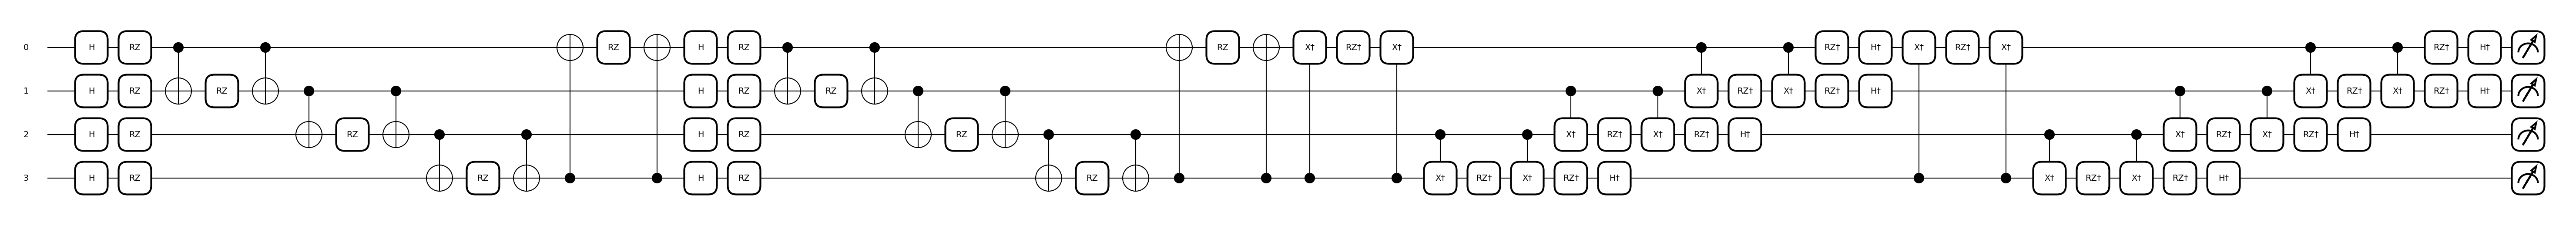

In [8]:
# qml.draw_mpl(IQP_layer._train_qnode, level=None)(torch.ones((16, 8 * 2)))
qml.draw_mpl(ZZ_layer._train_qnode)(torch.ones((16, 8 * 2)))
plt.show()

### Training Utils

##### Naive trainer

In [9]:
def train(model, X_train, Y_train, optimizer, epoch, batch_size, device):
    model = model.to(device)

    loss_fn = nn.MSELoss()
    train_loss = []

    model.train()
    for i in trange(epoch, desc=f'{model.__class__.__name__}'):
        X1, X2, Y = get_random_data(batch_size, X_train, Y_train)
        X1, X2, Y = X1.to(device), X2.to(device), Y.to(device)

        output = model(X1, X2)
        loss = loss_fn(output, Y)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
        if i % 200 == 0:
            print(f'Epoch [{i:>4}] Loss: {loss.item():.6f}')

    return train_loss


##### Early-stopping trainer

In [10]:
def build_train_loader(X_train, Y_train, batch_size, *, n=5000):
    train_loader = []
    for i in range(n):
        X1, X2, Y = get_random_data(batch_size, X_train, Y_train)
        train_loader.append((X1, X2, Y))
    return train_loader


def build_validation_loader(X_val, Y_val, batch_size, *, n=32):
    val_loader = []
    for i in range(n):
        X1, X2, Y = get_random_data(batch_size, X_val, Y_val)
        val_loader.append((X1, X2, Y))
    return val_loader

@torch.no_grad()
def compute_val_loss(model, val_loader, loss_fn, device):
    model.eval()
    acc_loss = 0.0
    # for X1, X2, Y in tqdm(val_loader, desc=f'Validating-{model.__class__.__name__}', leave=False):
    #     X1, X2, Y = X1.to(device), X2.to(device), Y.to(device)
    #     out = model(X1, X2)
    #     acc_loss += float(loss_fn(out, Y).item())
    for X1, X2, Y in val_loader:
        X1, X2, Y = X1.to(device), X2.to(device), Y.to(device)
        out = model(X1, X2)
        acc_loss += float(loss_fn(out, Y).item())
    return acc_loss / len(val_loader)


In [11]:
class EarlyStopper:
    def __init__(self, patience=300, min_delta=1e-4, warmup=100):
        self.patience = patience
        self.min_delta = min_delta
        self.warmup = warmup
        self.best = float("inf")
        self.best_state = None
        self.best_step = -1

    def step(self, val_loss, step, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.best_step = step
            # keep a lightweight copy of state dict
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            return False, True  # (should_stop, improved_now)
        # stop only after warmup and patience exceeded
        should_stop = (step >= self.warmup) and (step - self.best_step >= self.patience)
        return should_stop, False


def train_with_early_stopping(model, train_loader, val_loader, optimizer,
                              *, max_steps=5000, batch_size=256, device=None,
                              validate_every=25, patience=300, warm_up=100,
                              min_delta=1e-4, scheduler=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    loss_fn = nn.MSELoss()
    stopper = EarlyStopper(patience=patience, min_delta=min_delta, warmup=warm_up)

    # Optional LR scheduler on plateau (monitors val loss)
    sched = None
    if scheduler:
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=max(validate_every//2, 20),
            threshold=min_delta, min_lr=1e-5
        )

    train_loss_hist, val_loss_hist = [], []
    grad_norm_hist, grad_var_hist  = [], []
    for step in trange(max_steps, desc=f'{model.__class__.__name__}'):
        # one SGD step on a random pair batch
        X1, X2, Y = train_loader[step]
        X1, X2, Y = X1.to(device), X2.to(device), Y.to(device)

        model.train()
        out = model(X1, X2)
        loss = loss_fn(out, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_hist.append(float(loss.item()))

        g2 = []
        for p in model.parameters():
            if p.grad is not None:
                g2.append(p.grad.detach().flatten()**2)
        g2 = torch.cat(g2)
        grad_norm_hist.append(g2.norm().item())
        grad_var_hist.append(g2.var().item())

        # periodic validation
        if (step % validate_every) == 0:
            vloss = compute_val_loss(model, val_loader, loss_fn, device)
            val_loss_hist.append(vloss)
            if sched is not None:
                sched.step(vloss)

            should_stop, improved = stopper.step(vloss, step, model)
            if step % (validate_every*4) == 0:
                print(f"[{step:>4}] train={train_loss_hist[-1]:.4f} val={vloss:.4f}"
                      f" best@{stopper.best_step}={stopper.best:.4f}")
            if should_stop:
                print(f"Early stop at step {step} (best val {stopper.best:.4f} @ {stopper.best_step})")
                break

    # restore best weights (if we improved at least once)
    if stopper.best_state is not None:
        model.load_state_dict(stopper.best_state)

    return {
        "train_loss": train_loss_hist,
        "val_loss": val_loss_hist,
        "grad_norm": grad_norm_hist,
        "grad_var": grad_var_hist,
        "best_val": stopper.best,
        "best_step": stopper.best_step,
        "final_step": step,
    }


In [12]:
def _rolling_mean(x, k):
    if len(x) == 0: return x
    k = max(1, min(k, len(x)))
    c = numpy.convolve(x, np.ones(k)/k, mode="valid")
    pad = np.full(k-1, c[0])
    return np.concatenate([pad, c])

def _robust_z(x):
    x = np.asarray(x, dtype=float)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return (x - med) / (1.4826 * mad)

def detect_anomalies(train_hist, val_hist, val_steps,
                     *, rel_div_factor=1.8, spike_z=8.0,
                     plateau_windows=10, overfit_tail=6):
    out = {"notes": [], "diverge_idx": [], "spike_idx": [], "nan_inf": False,
           "plateau": False, "overfitting": False, "best_idx": None}

    v = np.asarray(val_hist, dtype=float)
    t = np.asarray(train_hist, dtype=float)

    if len(v) == 0:
        out["notes"].append("No validation points recorded.")
        return out

    out["nan_inf"] = (not np.all(np.isfinite(v))) or (not np.all(np.isfinite(t)))
    if out["nan_inf"]:
        out["notes"].append("NaN/Inf detected in loss history.")

    # Divergence: jump far above previous best, and trending up
    prev_best = numpy.minimum.accumulate(v[:-1]) if len(v) > 1 else numpy.array([v[0]])
    ratios = np.empty_like(v); ratios[:] = np.nan
    if len(v) > 1:
        ratios[1:] = v[1:] / numpy.maximum(prev_best, 1e-12)
        rising = numpy.r_[False, np.diff(v) > 0]
        div_idx = np.where((ratios > rel_div_factor) & rising)[0].tolist()
        out["diverge_idx"] = div_idx
        if div_idx:
            out["notes"].append(f"Divergence spikes at val iters {div_idx} (x>{rel_div_factor:.1f} of prior best).")

    # Instability: robust z on first-differences
    if len(v) > 2:
        dz = _robust_z(np.diff(v))
        spike_idx = np.where(np.abs(dz) > spike_z)[0] + 1
        out["spike_idx"] = spike_idx.tolist()
        if len(spike_idx):
            out["notes"].append(f"Instability spikes at val iters {out['spike_idx']} (|z|>{spike_z}).")

    # Plateau: no new best for N validation windows
    best_idx = int(numpy.argmin(v))
    out["best_idx"] = best_idx
    since_best = (len(v) - 1) - best_idx
    if since_best >= plateau_windows:
        out["plateau"] = True
        out["notes"].append(f"Plateau: no improvement for {since_best} validations.")

    # Overfitting: val increasing while train decreasing over the tail
    tail = min(overfit_tail, len(v))
    if tail >= 3:
        # align train to val windows by averaging train losses between validations
        seg_means = []
        for k in range(len(v)):
            left = 0 if k == 0 else val_steps[k-1]
            right = val_steps[k] if k < len(val_steps) else len(t)-1
            seg = t[left:right+1] if right >= left else t[max(0, right-5):right+1]
            seg_means.append(np.mean(seg) if len(seg) else np.nan)
        seg_means = np.array(seg_means, dtype=float)

        xv = np.arange(len(v))
        # simple slopes on the recent tail
        sv = numpy.polyfit(xv[-tail:], v[-tail:], 1)[0]
        st = numpy.polyfit(xv[-tail:], seg_means[-tail:], 1)[0] if np.all(np.isfinite(seg_means[-tail:])) else 0.0
        if sv > 0 and st < 0:
            out["overfitting"] = True
            out["notes"].append(f"Overfitting signature on last {tail} validations (val↑, train↓).")

    if not out["notes"]:
        out["notes"].append("No anomalies detected.")
    return out

def notify_anomalies(history: dict, topic: str, validate_every: int = 25, run_name: str = "Run", ntfy: bool=True,
                     *, logy=False, priority="high"):
    train_hist = history.get("train_loss", [])
    val_hist   = history.get("val_loss", [])
    final_step = int(history.get("final_step", len(train_hist)-1))

    # Validation steps (x positions of val points)
    val_steps = np.arange(0, validate_every*len(val_hist), validate_every, dtype=int)
    if len(val_hist) and (val_steps[-1] > final_step):
        # clamp just in case
        val_steps = np.clip(val_steps, 0, final_step)

    # Detect anomalies
    an = detect_anomalies(train_hist, val_hist, val_steps)
    best_idx = an["best_idx"] if an["best_idx"] is not None else 0
    best_step = val_steps[best_idx] if len(val_steps) else 0

    # ---- Make plot ----
    fig, ax = plt.subplots(figsize=(7.0, 4.0))
    ax.plot(np.arange(len(train_hist)), train_hist, lw=1.0, alpha=0.65, label="train")
    if len(val_hist):
        ax.plot(val_steps, val_hist, marker="o", ms=4, lw=1.0, label="val")
        # Best
        ax.axvline(best_step, ls="--", lw=1.0, alpha=0.6)
        ax.text(best_step, np.min(val_hist), " best", va="bottom", ha="left", fontsize=8)
        # Divergence spikes
        if an["diverge_idx"]:
            ax.scatter(val_steps[an["diverge_idx"]], np.array(val_hist)[an["diverge_idx"]],
                       marker="x", s=60, label="diverge", c='r')
        # Instability spikes
        if an["spike_idx"]:
            ax.scatter(val_steps[an["spike_idx"]], np.array(val_hist)[an["spike_idx"]],
                       marker="^", s=60, label="instability", c='b')
    ax.set_title(f"{run_name}: loss history")
    ax.set_xlabel("step"); ax.set_ylabel("loss")
    if logy: ax.set_yscale("log")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

    # Render to PNG buffer
    buf = io.BytesIO()
    plt.savefig(buf, format="png", dpi=180, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)

    # Compose summary text
    summary = (f"{run_name} anomalies\n"
               f"- final_step: {final_step}\n"
               f"- best val@{best_step}: {np.min(val_hist) if len(val_hist) else np.nan:.4f}\n"
               f"- notes: " + " ".join(an["notes"]))
    print(summary)  # also print to notebook logs

    if not ntfy:
        return

    # ---- Send to ntfy ----
    url = f"https://ntfy.sh/{topic}"

    # 1) Image with short title
    headers_img = {
        "Title": f"Colab: {run_name} - plot" if len(an['notes']) == 1 and "No anomalies" in an["notes"][0]
                 else f"Colab: {run_name} - anomalies detected",
        "Priority": priority,
        "Filename": f"{run_name.replace(' ', '_').lower()}_loss.png",
        "Content-Type": "image/png",
        "Tags": "chart,warning" if ("No anomalies" not in an["notes"][0]) else "chart,white_check_mark",
    }
    r1 = requests.post(url, data=buf.getvalue(), headers=headers_img, timeout=30)

    # 2) Text summary
    headers_txt = {
        "Title": f"{run_name} - anomaly summary",
        "Content-Type": "text/plain; charset=utf-8",
    }
    r2 = requests.post(url, data=summary.encode("utf-8"), headers=headers_txt, timeout=30)

    print("ntfy image status:", r1.status_code, r1.text[:120])
    print("ntfy text  status:", r2.status_code, r2.text[:120])

# NQE Class

In [13]:
class Stacking(nn.Module):
    def __init__(self, n_layers: int):
        super(Stacking, self).__init__()
        self.n_layers = n_layers

    def forward(self, x):
        return torch.stack([x for _ in range(self.n_layers)], dim=-1).reshape(x.size(0), -1)


In [14]:
class NQE(nn.Module):
    def __init__(self,
                 in_dims : int,
                 n_qubits: int,
                 n_layers: int,
                 hidden_dims: int | List[int],
                 q_embedding: QLayer):
        super(NQE, self).__init__()
        self.in_dims  = in_dims
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims]
        else:
            self.hidden_dims = hidden_dims
        self.q_embedding = q_embedding

        layers = []
        layers.append(nn.Linear(in_dims, self.hidden_dims[0]))
        layers.append(nn.ReLU())
        for h_dim1, h_dim2 in pairwise(self.hidden_dims):
            layers.append(nn.Linear(h_dim1, h_dim2))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dims[-1], n_qubits))
        # layers.append(nn.Tanh())
        self.linear = nn.Sequential(*layers)

        self.stacking = Stacking(n_layers)

        self.c_layer = nn.Sequential(
            self.linear,
            self.stacking
        )
        self.q_layer = qml.qnn.TorchLayer(self.q_embedding._train_qnode, weight_shapes={})

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.linear(x1)    # (B, nq)
        x2 = self.linear(x2)    # (B, nq)
        x = torch.concat([x1, x2], dim=1)  # (B, 2*nq)
        x = self.stacking(x)  # (B, 2*nq, L) -> (B, 2*nq*L)
        x = self.q_layer(x)
        return x[:,0]  # (B)


In [15]:
# input_dims = 4
# n_qubits = 4
# n_layers = 1
# hidden_dims = [8]

# model = NQE(in_dims=input_dims,
#             n_qubits=n_qubits,
#             n_layers=n_layers,
#             hidden_dims=hidden_dims,
#             q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# X_train, Y_train, X_test, Y_test = load_mnist_pca(input_dims)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train_loss = train(model, X_train, Y_train, optimizer, epoch=1000, batch_size=128, device=device)

# plt.plot(train_loss)
# plt.show()

In [16]:
@torch.no_grad()
def _dm_batch_from_inputs(model, Xb: torch.Tensor) -> np.ndarray:
    """
    Xb: (B, in_dims) on model.device
    Returns: (B, 2, 2) complex numpy density matrices
    """
    model.eval()
    qfeat = model.c_layer(Xb)                      # (B, n_qubits * n_layers)
    rho = model.q_embedding._dm_qnode(qfeat) # (B, 2, 2), complex torch
    return rho.detach().cpu().numpy()

def _bloch_from_dm(dm_batch: np.ndarray):
    """
    dm_batch: (B,2,2) complex
    Returns: x,y,z each shape (B,)
    """
    # Pauli matrices
    sx = np.array([[0,1],
                   [1,0]],  dtype=np.complex128)
    sy = np.array([[0,-1j],
                   [1j,0]], dtype=np.complex128)
    sz = np.array([[1,0],
                   [0,-1]], dtype=np.complex128)
    # trace(dm @ sigma) for each batch
    xs = np.real(np.trace(dm_batch @ sx, axis1=1, axis2=2))
    ys = np.real(np.trace(dm_batch @ sy, axis1=1, axis2=2))
    zs = np.real(np.trace(dm_batch @ sz, axis1=1, axis2=2))
    return xs, ys, zs

def _plot_bloch_points(x0,y0,z0, x1,y1,z1, *, title="Bloch sphere: class clusters"):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (ensures 3D registered)
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    # sphere mesh
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(xs, ys, zs, rstride=2, cstride=2, alpha=0.08, linewidth=0)

    # axes
    ax.plot([-1,1],[0,0],[0,0], alpha=0.3, lw=1)
    ax.plot([0,0],[-1,1],[0,0], alpha=0.3, lw=1)
    ax.plot([0,0],[0,0],[-1,1], alpha=0.3, lw=1)

    # points
    ax.scatter(x0,y0,z0, s=20, label="class 0", depthshade=False, marker='o')
    ax.scatter(x1,y1,z1, s=20, label="class 1", depthshade=False, marker='s')

    # means (arrows)
    m0 = np.array([x0.mean(), y0.mean(), z0.mean()])
    m1 = np.array([x1.mean(), y1.mean(), z1.mean()])
    ax.scatter(m0[0], m0[1], m0[2], label='mean class 0', depthshade=False, marker='o', c='b')
    ax.scatter(m1[0], m1[1], m1[2], label='mean class 1', depthshade=False, marker='s', c='r')
    ax.quiver(0,0,0, m0[0],m0[1],m0[2], normalize=False, colors='b')
    ax.quiver(0,0,0, m1[0],m1[1],m1[2], normalize=False, colors='r')

    ax.set_box_aspect((1,1,1))
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title(title)
    ax.legend(loc="upper left")
    plt.show()

input_dims = 4
n_qubits = 1
n_layers = 1
hidden_dims = [6]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nqe_vis = NQE(in_dims=input_dims,
            n_qubits=n_qubits,
            n_layers=n_layers,
            hidden_dims=hidden_dims,
            q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))
optimizer = torch.optim.AdamW(nqe_vis.parameters(), lr=1e-2, weight_decay=1e-2)

X_train, Y_train, X_test, Y_test = load_mnist_pca(input_dims)

K = 10  # points per class to visualize
idx0 = np.where(Y_test == 0)[0][:K]
idx1 = np.where(Y_test == 1)[0][:K]
Xt0 = torch.as_tensor(X_test[idx0], dtype=torch.float32, device=device)
Xt1 = torch.as_tensor(X_test[idx1], dtype=torch.float32, device=device)

nqe_vis = nqe_vis.to(device)

loss_fn = nn.MSELoss()
train_loss = []
dm_list = []

# nqe_vis.train()
# for i in trange(1000, desc=f'{nqe_vis.__class__.__name__}'):
#     X1, X2, Y = get_random_data(128, X_train, Y_train)
#     X1, X2, Y = X1.to(device), X2.to(device), Y.to(device)

#     output = nqe_vis(X1, X2)
#     loss = loss_fn(output, Y)

#     optimizer.zero_grad()
#     loss.backward()

#     optimizer.step()

#     train_loss.append(loss.item())
#     if i % 200 == 0:
#         print(f'Epoch [{i:>4}] Loss: {loss.item():.6f}')

#         # ---- embed and get density matrices in batch ----
#         dm0 = _dm_batch_from_inputs(nqe_vis, Xt0)  # (K,2,2)
#         dm1 = _dm_batch_from_inputs(nqe_vis, Xt1)  # (K,2,2)
#         dm_list.append((dm0, dm1))


# for i, (dm0, dm1) in enumerate(dm_list):
#     # ---- convert to Bloch coordinates ----
#     x0,y0,z0 = _bloch_from_dm(dm0)
#     x1,y1,z1 = _bloch_from_dm(dm1)

#     # ---- plot ----
#     _plot_bloch_points(x0,y0,z0, x1,y1,z1, title=f"NQE test states on Bloch sphere({i*200} iters)")



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.44MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.04MB/s]


# Metrics

In [17]:
class Metric(nn.Module):
    def __init__(self, model):
        super(Metric, self).__init__()
        self.c_layer = model.c_layer
        self.q_layer = model.q_embedding._dm_qnode

    def separability(self, x0, x1, mode: Literal['Tr', 'HS'], trained: bool):
        if trained:
            self.c_layer.eval()

            x0 = self.c_layer(x0)
            x1 = self.c_layer(x1)

        rhos0 = self.q_layer(x0)
        rhos1 = self.q_layer(x1)

        # Calculate the mean density matrix for each set of inputs
        rho0 = torch.mean(rhos0, dim=0)
        rho1 = torch.mean(rhos1, dim=0)

        diff = rho1 - rho0

        if mode == 'Tr':       # Trace distance
            eigvals = torch.linalg.eigvalsh(diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        elif mode == 'HS':     # Hilbert-Schmidt inner-product
            return 0.5 * torch.real(torch.trace(diff @ diff))
        else:
            raise ValueError(f"Invalid mode: {mode}")

    def centered_kernel_alignment(self, x, y, trained: bool):
        if trained:
            self.c_layer.eval()

            x = self.c_layer(x)

        rhos = self.q_layer(x)

        B = rhos.size(0)
        K = torch.real(torch.einsum('bij,cji->bc', rhos, rhos)).to(torch.float32)  # (B,B)
        H = torch.eye(B, device=K.device) - torch.ones((B,B), device=K.device) / B

        Kc = H @ K @ H
        Ky = torch.ger(y, y)
        Ky_c = H @ Ky @ H
        num = torch.sum(Kc*Ky_c)
        den = torch.linalg.norm(Kc, 'fro') * torch.linalg.norm(Ky_c, 'fro')
        return float((num/den).item())


In [18]:
# idx0_train = np.where(Y_train == 0)[0]
# idx1_train = np.where(Y_train == 1)[0]
# X0_train = torch.as_tensor(X_train[idx0_train], dtype=torch.float32, device=device)
# X1_train = torch.as_tensor(X_train[idx1_train], dtype=torch.float32, device=device)

# idx0_test = np.where(Y_test == 0)[0]
# idx1_test = np.where(Y_test == 1)[0]
# X0_test = torch.as_tensor(X_test[idx0_test], dtype=torch.float32, device=device)
# X1_test = torch.as_tensor(X_test[idx1_test], dtype=torch.float32, device=device)

# print(f'{"Trace Distance":=^25}')
# metric = Metric(model)
# before = metric.separability(X0_train, X1_train, 'Tr', trained=False)
# after  = metric.separability(X0_train, X1_train, 'Tr', trained=True)
# print(f'[Train] Before training: {before:.6f}')
# print(f'[Train] After  training: {after:.6f}')

# before = metric.separability(X0_test, X1_test, 'Tr', trained=False)
# after  = metric.separability(X0_test, X1_test, 'Tr', trained=True)
# print(f'[Test]  Before training: {before:.6f}')
# print(f'[Test]  After  training: {after:.6f}')

# print(f'{"Fidelity Gap":=^25}')
# before = metric.separability(X0_train, X1_train, 'HS', trained=False)
# after  = metric.separability(X0_train, X1_train, 'HS', trained=True)
# print(f'[Train] Before training: {before:.6f}')
# print(f'[Train] After  training: {after:.6f}')

# before = metric.separability(X0_test, X1_test, 'HS', trained=False)
# after  = metric.separability(X0_test, X1_test, 'HS', trained=True)
# print(f'[Test]  Before training: {before:.6f}')
# print(f'[Test]  After  training: {after:.6f}')

# X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
# Y_test = torch.as_tensor(Y_test, dtype=torch.float32, device=device)

# print(f'{"QKA":=^25}')
# before = metric.centered_kernel_alignment(X_test, Y_test, trained=False)
# after  = metric.centered_kernel_alignment(X_test, Y_test, trained=True)
# print(f'[Test] Before training: {before:.6f}')
# print(f'[Test] After  training: {after:.6f}')

In [ ]:
class QFIMTracker:
    """
    QFIM (Fubini–Study) tracker for the *quantum* parameters.
    Computes the metric for a given mini-batch of classical inputs by averaging
    per-sample QFIMs (since QFIM is input-dependent).

    Usage:
        tracker = QFIMTracker(nqe=model.nqe, ansatz=qcnn.ansatz, dev=qcnn.nqe.q_embedding.dev)
        out = tracker.summary(X_batch[:8], qcnn.params)
    """
    def __init__(self, nqe, ansatz, dev):
        self.nqe = nqe
        self.ansatz = ansatz
        self.dev = dev

        # A pure-state QNode used to compute the metric tensor (no measurement other than state).
        @qml.qnode(device=dev, interface='torch')
        def _state_qnode(inputs, params):
            # reuse the same embedding as QCNN
            nqe.q_embedding._embedding(inputs)
            ansatz.apply(params)
            return qml.state()

        self._state_qnode = _state_qnode

        # PennyLane metric-tensor callable; returns the Fubini-Study metric g(θ)
        # w.r.t. *trainable* params in the QNode (here: `params`).
        self._mt_fn = qml.metric_tensor(self._state_qnode)

    @torch.no_grad()
    def qfim(self, Xb: torch.Tensor, params: torch.Tensor, max_samples: int | None = 8) -> torch.Tensor:
        """
        Returns the *average* QFIM over up to `max_samples` items from Xb.
        Shapes:
            Xb: (B, in_dim)  classical inputs
            params: (P,)     quantum parameter vector (e.g., QCNN.params)
        """
        if max_samples is None:
            max_samples = Xb.shape[0]
        m = min(int(max_samples), int(Xb.shape[0]))

        Fs, ok = [], True
        for i in range(m):
            xi = Xb[i:i+1]          # keep batch dim = 1
            try:
                # metric tensor g (PyTorch tensor on CPU). Ensure symmetry explicitly.
                g = self._mt_fn(xi.cpu(), params.detach().cpu())
                g = torch.as_tensor(g, dtype=torch.get_default_dtype())
                g = 0.5 * (g + g.T)
                F = 4.0 * g          # QFIM
                Fs.append(F)
            except Exception as e:
                ok = False
                break

        if ok and Fs:
            return torch.stack(Fs, dim=0).mean(dim=0)  # (P,P)
        else:
            raise RuntimeError("QFIM not available (likely noisy/mixed/shots device).")

    @staticmethod
    @torch.no_grad()
    def trainability_from_qfim(F: torch.Tensor) -> dict:
        """Compute scalar trainability summaries from a (P,P) QFIM."""
        # numerical symmetrization (just in case)
        F = 0.5 * (F + F.T)
        # eigenvalues (PSD) — add tiny jitter for numerical stability
        eps = 1e-12
        evals = torch.linalg.eigvalsh(F + eps*torch.eye(F.shape[0], dtype=F.dtype))
        trace = torch.clamp(evals, min=0).sum().item()
        lam_min = float(evals.min().item())
        lam_max = float(evals.max().item())
        cond = float(lam_max / max(lam_min, eps))
        return {
            "trace": trace,
            "lambda_min": lam_min,
            "lambda_max": lam_max,
            "condition_number": cond,
        }

    @torch.no_grad()
    def summary(self, Xb: torch.Tensor, params: torch.Tensor, max_samples: int | None = 8,
                grad_proxy_model: torch.nn.Module | None = None,
                grad_proxy_loss: torch.nn.Module | None = None,
                grad_proxy_batch: tuple | None = None) -> dict:
        """
        Full summary: QFIM + optional gradient proxy (when QFIM not available or to complement it).
        """
        out = {}
        try:
            F = self.qfim(Xb, params, max_samples=max_samples)
            out["qfim"] = F
            out.update(self.trainability_from_qfim(F))
        except RuntimeError:
            out["qfim"] = None

        # Optional gradient-norm proxy: useful under noise/shots or to complement QFIM
        if grad_proxy_model is not None and grad_proxy_loss is not None and grad_proxy_batch is not None:
            Xg, Yg = grad_proxy_batch
            # zero grads and compute one backward pass
            for p in grad_proxy_model.parameters():
                if p.grad is not None:
                    p.grad.zero_()
            pred = grad_proxy_model(Xg)
            loss = grad_proxy_loss(pred, Yg.float())
            loss.backward()
            # aggregate over *quantum* params only if desired
            grads = []
            for name, p in grad_proxy_model.named_parameters():
                if p.grad is None:
                    continue
                # example: only include the QCNN quantum params vector named 'params'
                if name.endswith("params"):
                    grads.append(p.grad.detach().flatten()**2)
            if grads:
                g2 = torch.cat(grads)
                out["grad_norm"] = float(torch.sqrt(torch.sum(g2)).item())
                out["grad_var"]  = float(torch.var(g2).item())
        return out


# NQE_BIG Class

In [19]:
NQE_repeat = NQE

class NQE_BIG(nn.Module):
    def __init__(self,
                 in_dims : int,
                 n_qubits: int,
                 n_layers: int,
                 hidden_dims: Optional[int | List[int]],
                 q_embedding: QLayer):
        super(NQE_BIG, self).__init__()
        self.in_dims  = in_dims
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims]
        else:
            self.hidden_dims = hidden_dims
        self.q_embedding = q_embedding

        layers = []
        layers.append(nn.Linear(in_dims, self.hidden_dims[0]))
        layers.append(nn.ReLU())
        for h_dim1, h_dim2 in pairwise(self.hidden_dims):
            layers.append(nn.Linear(h_dim1, h_dim2))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dims[-1], n_qubits * n_layers))
        # layers.append(nn.Tanh())

        self.linear = nn.Sequential(*layers)

        self.c_layer = nn.Sequential(
            self.linear,
        )
        self.q_layer = qml.qnn.TorchLayer(self.q_embedding._train_qnode, weight_shapes={})

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.linear(x1)   # (B, nq*L)
        x2 = self.linear(x2)
        x1 = x1.reshape([-1, self.n_qubits, self.n_layers])
        x2 = x2.reshape([-1, self.n_qubits, self.n_layers])
        x = torch.concat([x1, x2], dim=1).reshape(x1.size(0), -1)  # (B, 2*nq*L)
        x = self.q_layer(x)
        return x[:,0]


# UCNQE Class

In [20]:
class UpConvolution1(nn.Module):
    """
    Given n dimensional vector, return n × m matrix.
    """
    def __init__(self, m):
        super(UpConvolution1, self).__init__()
        self.weight = nn.Parameter(torch.empty(1, m))
        nn.init.xavier_uniform_(self.weight) # Initialize with Xavier uniform
        # nn.init.ones_(self.weight)

    def forward(self, x):
        # x has shape (B, n)
        # self.weight has shape (1, m)

        # Unsqueeze to enable broadcasting
        x = x.unsqueeze(2)  # (B, n, 1)
        weight_broadcastable = self.weight.unsqueeze(0)  # (1, 1, m)

        # Perform element-wise multiplication with broadcasting
        # (B, n, 1) * (1, 1, m) -> (B, n, m)
        output = x * weight_broadcastable

        return output.reshape(x.size(0), -1)

class UpConvolution2(nn.Module):
    def __init__(self, n, m):
        super(UpConvolution2, self).__init__()
        self.weight = nn.Parameter(torch.empty(n, m))
        nn.init.xavier_uniform_(self.weight) # Initialize with Xavier uniform
        # nn.init.ones_(self.weight)

    def forward(self, x):
        # x has shape (B, n)
        # self.weight has shape (n, m)

        # Unsqueeze to enable broadcasting
        x = x.unsqueeze(2)  # (B, n, 1)
        weight_broadcastable = self.weight.unsqueeze(0)  # (1, n, m)

        # Perform element-wise multiplication with broadcasting
        # (B, n, 1) * (1, n, m) -> (B, n, m)
        output = x * weight_broadcastable

        return output.reshape(x.size(0), -1)

In [21]:
uconv1 = UpConvolution1(5)
uconv2 = UpConvolution2(4, 5)  # m = 5

a = torch.rand(10, 4)  # n = 4

print(f'Original shape: {a.shape}')  # (B, n)

# (B, n, m) -> (B, n*m)
print(f'UpConvolution1 Output shape: {uconv1(a).shape}')
print(f'UpConvolution2 Output shape: {uconv2(a).shape}')

# (1, m)
print(f'UpConvolution1 weight shape: {uconv1.weight.shape}')
print(f'UpConvolution2 weight shape: {uconv2.weight.shape}')

Original shape: torch.Size([10, 4])
UpConvolution1 Output shape: torch.Size([10, 20])
UpConvolution2 Output shape: torch.Size([10, 20])
UpConvolution1 weight shape: torch.Size([1, 5])
UpConvolution2 weight shape: torch.Size([4, 5])


In [22]:
class UCNQE(nn.Module):
    def __init__(self,
                 in_dims : int,
                 n_qubits: int,
                 n_layers: int,
                 hidden_dims: Optional[int | List[int]],
                 q_embedding: QLayer,
                 mode: Literal['single', 'block']):
        super(UCNQE, self).__init__()
        self.in_dims  = in_dims
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims]
        else:
            self.hidden_dims = hidden_dims
        self.q_embedding = q_embedding

        layers = []
        layers.append(nn.Linear(in_dims, self.hidden_dims[0]))
        layers.append(nn.ReLU())
        for h_dim1, h_dim2 in pairwise(self.hidden_dims):
            layers.append(nn.Linear(h_dim1, h_dim2))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dims[-1], n_qubits))
        layers.append(nn.ReLU())

        self.linear  = nn.Sequential(*layers)
        if mode == 'single':
            self.up_conv = UpConvolution1(n_layers)
        elif mode=='block':
            self.up_conv = UpConvolution2(n_qubits, n_layers)
        self.tanh = nn.Tanh()

        self.c_layer = nn.Sequential(
            self.linear,
            self.up_conv,
            # self.tanh
        )
        self.q_layer = qml.qnn.TorchLayer(self.q_embedding._train_qnode, weight_shapes={})

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.linear(x1)   # (B, nq)
        x2 = self.linear(x2)   # (B, nq)
        x1 = self.up_conv(x1)  # (B, nq*L)
        x2 = self.up_conv(x2)  # (B, nq*L)
        x = torch.concat([x1, x2], dim=1) # (B, 2*nq*L)
        # x = self.tanh(x)
        x = self.q_layer(x)
        return x[:,0]

# Testing `n_layers`' impact

In [63]:
# ----- Hyper-Params -----
n_qubits = 2
input_dims = 4
hidden_dims = [8]
n_layers_list = [1, 2, 3, 4,]
batch_size = 128
max_steps = 1000
patience = 300
warm_up = 100
avg_at = 3

# ----- Results Containers -----
tr_list  = torch.empty((4, len(n_layers_list), avg_at))  # trace distance
hs_list  = torch.empty((4, len(n_layers_list), avg_at))  # HS inner-product
qka_list = torch.empty((4, len(n_layers_list), avg_at))  # QKA

param_size_list = torch.empty((4, len(n_layers_list)))

# ----- Dataset -----
X_train, Y_train, X_test, Y_test = load_mnist_pca(input_dims)
# X_train, Y_train, X_test, Y_test = load_fashion_mnist_pca(input_dims)

val_frac = 0.1
n = len(X_train)
idx = numpy.random.permutation(n)
cut = int(n*(1.0 - val_frac))
tr_idx, va_idx = idx[:cut], idx[cut:]
X_va, Y_va = X_train[va_idx], Y_train[va_idx]
X_tr, Y_tr = X_train[tr_idx], Y_train[tr_idx]

idx0_test = np.where(Y_test == 0)[0]
idx1_test = np.where(Y_test == 1)[0]
X0_test = torch.as_tensor(X_test[idx0_test], dtype=torch.float32, device=device)
X1_test = torch.as_tensor(X_test[idx1_test], dtype=torch.float32, device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(Y_test, dtype=torch.float32, device=device)

# ----- Main Loop -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, n_layers in enumerate(n_layers_list):
    print(f'[Number of layers: {n_layers}]')
    for j in range(avg_at):
        print(f'[{j+1}/{avg_at}]')
        model0 = NQE(in_dims=input_dims,
                     n_qubits=n_qubits,
                     n_layers=n_layers,
                     hidden_dims=hidden_dims,
                     q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))
        model1 = NQE_BIG(in_dims=input_dims,
                         n_qubits=n_qubits,
                         n_layers=n_layers,
                         hidden_dims=hidden_dims,
                         q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))
        model2 = UCNQE(in_dims=input_dims,
                       n_qubits=n_qubits,
                       n_layers=n_layers,
                       hidden_dims=hidden_dims,
                       q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits),
                       mode='single')
        model3 = UCNQE(in_dims=input_dims,
                       n_qubits=n_qubits,
                       n_layers=n_layers,
                       hidden_dims=hidden_dims,
                       q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits),
                       mode='block')


        # optimizer0 = torch.optim.SGD(model0.parameters(), lr=1e-2)
        # optimizer1 = torch.optim.SGD(model1.parameters(), lr=1e-2)
        # optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-2)
        # optimizer3 = torch.optim.SGD(model3.parameters(), lr=1e-2)
        optimizer0 = torch.optim.Adam(model0.parameters(), lr=1e-2)
        optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-2)
        optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-2)
        optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-2)

        train_loader = build_train_loader(X_tr, Y_tr, batch_size, n=max_steps)
        val_loader   = build_validation_loader(X_va, Y_va, batch_size, n=32)

        nqe_res = train_with_early_stopping(model0, train_loader, val_loader, optimizer0,
                                            max_steps=max_steps, batch_size=batch_size,
                                            patience=patience, warm_up=warm_up, scheduler=False,
                                            device=device)
        notify_anomalies(nqe_res,    topic='training-anomaly-report', run_name=f'NQE-L{n_layers}-{j}',
                         ntfy=False, priority='default')

        metric = Metric(model0)
        tr_list[0][i][j] = metric.separability(X0_test, X1_test, 'Tr', trained=True)
        hs_list[0][i][j] = metric.separability(X0_test, X1_test, 'HS', trained=True)
        qka_list[0][i][j] = metric.centered_kernel_alignment(X_test, Y_test, trained=True)
        print(f'[Tr] NQE-L{n_layers}-{j}: {tr_list[0][i][j]:.6f}')
        print(f'[HS] NQE-L{n_layers}-{j}: {hs_list[0][i][j]:.6f}')

        nqebig_res = train_with_early_stopping(model1, train_loader, val_loader, optimizer1,
                                               max_steps=max_steps, batch_size=batch_size,
                                               patience=patience, warm_up=warm_up, scheduler=False,
                                               device=device)
        notify_anomalies(nqebig_res, topic='training-anomaly-report', run_name=f'NQE_Big-L{n_layers}-{j}',
                         ntfy=False, priority='default')

        metric = Metric(model1)
        tr_list[1][i][j] = metric.separability(X0_test, X1_test, 'Tr', trained=True)
        hs_list[1][i][j] = metric.separability(X0_test, X1_test, 'HS', trained=True)
        qka_list[1][i][j] = metric.centered_kernel_alignment(X_test, Y_test, trained=True)
        print(f'[Tr] NQE_Big-L{n_layers}-{j}: {tr_list[1][i][j]:.6f}')
        print(f'[HS] NQE_Big-L{n_layers}-{j}: {hs_list[1][i][j]:.6f}')

        ucnqe1_res = train_with_early_stopping(model2, train_loader, val_loader, optimizer2,
                                              max_steps=max_steps, batch_size=batch_size,
                                              patience=patience, warm_up=warm_up, scheduler=False,
                                              device=device)
        notify_anomalies(ucnqe1_res,  topic='training-anomaly-report', run_name=f'UCNQE-L{n_layers}-{j}',
                         ntfy=False, priority='high')

        metric = Metric(model2)
        tr_list[2][i][j] = metric.separability(X0_test, X1_test, 'Tr', trained=True)
        hs_list[2][i][j] = metric.separability(X0_test, X1_test, 'HS', trained=True)
        qka_list[2][i][j] = metric.centered_kernel_alignment(X_test, Y_test, trained=True)
        print(f'[Tr] UCNQE1-L{n_layers}-{j}: {tr_list[2][i][j]:.6f}')
        print(f'[HS] UCNQE1-L{n_layers}-{j}: {hs_list[2][i][j]:.6f}')

        ucnqe2_res = train_with_early_stopping(model3, train_loader, val_loader, optimizer3,
                                              max_steps=max_steps, batch_size=batch_size,
                                              patience=patience, warm_up=warm_up, scheduler=False,
                                              device=device)
        notify_anomalies(ucnqe2_res,  topic='training-anomaly-report', run_name=f'UCNQE-L{n_layers}-{j}',
                         ntfy=False, priority='high')

        metric = Metric(model3)
        tr_list[3][i][j] = metric.separability(X0_test, X1_test, 'Tr', trained=True)
        hs_list[3][i][j] = metric.separability(X0_test, X1_test, 'HS', trained=True)
        qka_list[3][i][j] = metric.centered_kernel_alignment(X_test, Y_test, trained=True)
        print(f'[Tr] UCNQE2-L{n_layers}-{j}: {tr_list[3][i][j]:.6f}')
        print(f'[HS] UCNQE2-L{n_layers}-{j}: {hs_list[3][i][j]:.6f}')

    params0 = sum(p.numel() for p in model0.parameters() if p.requires_grad)
    params1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
    params2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
    params3 = sum(p.numel() for p in model3.parameters() if p.requires_grad)
    param_size_list[0][i] = (params0)
    param_size_list[1][i] = (params1)
    param_size_list[2][i] = (params2)
    param_size_list[3][i] = (params3)

[Number of layers: 1]
[1/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3198 val=0.2954 best@0=0.2954
[ 100] train=0.0381 val=0.0349 best@100=0.0349
[ 200] train=0.0445 val=0.0210 best@175=0.0195
[ 300] train=0.0080 val=0.0062 best@250=0.0060
[ 400] train=0.0063 val=0.0058 best@325=0.0058
[ 500] train=0.0070 val=0.0058 best@475=0.0050
[ 600] train=0.0130 val=0.0057 best@575=0.0047
[ 700] train=0.0031 val=0.0042 best@650=0.0041
[ 800] train=0.0074 val=0.0041 best@750=0.0039
[ 900] train=0.0011 val=0.0039 best@875=0.0035
NQE-L1-0 anomalies
- final_step: 999
- best val@875: 0.0035
- notes: Instability spikes at val iters [1, 2, 3, 4, 7, 9] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] NQE-L1-0: 0.985419
[HS] NQE-L1-0: 0.970165


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2891 val=0.2803 best@0=0.2803
[ 100] train=0.0686 val=0.0703 best@100=0.0703
[ 200] train=0.1107 val=0.0723 best@175=0.0700
[ 300] train=0.0679 val=0.0642 best@300=0.0642
[ 400] train=0.0072 val=0.0063 best@400=0.0063
[ 500] train=0.0038 val=0.0054 best@450=0.0053
[ 600] train=0.0111 val=0.0048 best@600=0.0048
[ 700] train=0.0039 val=0.0054 best@675=0.0044
[ 800] train=0.0064 val=0.0056 best@675=0.0044
[ 900] train=0.0009 val=0.0053 best@875=0.0042
NQE_Big-L1-0 anomalies
- final_step: 999
- best val@875: 0.0042
- notes: Divergence spikes at val iters [30] (x>1.8 of prior best). Instability spikes at val iters [1, 2, 14, 15] (|z|>8.0).
[Tr] NQE_Big-L1-0: 0.982518
[HS] NQE_Big-L1-0: 0.963888


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3057 val=0.3112 best@0=0.3112
[ 100] train=0.0323 val=0.0278 best@100=0.0278
[ 200] train=0.0164 val=0.0181 best@200=0.0181
[ 300] train=0.0130 val=0.0137 best@300=0.0137
[ 400] train=0.0230 val=0.0179 best@350=0.0130
[ 500] train=0.0140 val=0.0168 best@350=0.0130
[ 600] train=0.0121 val=0.0115 best@550=0.0091
[ 700] train=0.0131 val=0.0094 best@550=0.0091
[ 800] train=0.0082 val=0.0084 best@800=0.0084
[ 900] train=0.0089 val=0.0087 best@875=0.0075
UCNQE-L1-0 anomalies
- final_step: 999
- best val@875: 0.0075
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE1-L1-0: 0.978362
[HS] UCNQE1-L1-0: 0.927373


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3479 val=0.3443 best@0=0.3443
[ 100] train=0.2121 val=0.1770 best@100=0.1770
[ 200] train=0.1011 val=0.1000 best@200=0.1000
[ 300] train=0.0285 val=0.0181 best@275=0.0172
[ 400] train=0.0317 val=0.0228 best@350=0.0169
[ 500] train=0.0094 val=0.0177 best@475=0.0150
[ 600] train=0.0179 val=0.0150 best@475=0.0150
[ 700] train=0.0199 val=0.0197 best@650=0.0141
[ 800] train=0.0082 val=0.0141 best@750=0.0099
[ 900] train=0.0157 val=0.0112 best@750=0.0099
UCNQE-L1-0 anomalies
- final_step: 999
- best val@750: 0.0099
- notes: Instability spikes at val iters [1] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE2-L1-0: 0.982920
[HS] UCNQE2-L1-0: 0.913942
[2/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2516 val=0.2366 best@0=0.2366
[ 100] train=0.0287 val=0.0392 best@100=0.0392
[ 200] train=0.0146 val=0.0239 best@200=0.0239
[ 300] train=0.0155 val=0.0145 best@300=0.0145
[ 400] train=0.0013 val=0.0113 best@400=0.0113
[ 500] train=0.0029 val=0.0112 best@425=0.0109
[ 600] train=0.0029 val=0.0109 best@550=0.0105
[ 700] train=0.0065 val=0.0114 best@625=0.0103
[ 800] train=0.0027 val=0.0101 best@725=0.0099
[ 900] train=0.0135 val=0.0109 best@725=0.0099
NQE-L1-1 anomalies
- final_step: 999
- best val@975: 0.0088
- notes: Instability spikes at val iters [1, 2] (|z|>8.0).
[Tr] NQE-L1-1: 0.989991
[HS] NQE-L1-1: 0.974920


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2756 val=0.3152 best@0=0.3152
[ 100] train=0.1799 val=0.1282 best@100=0.1282
[ 200] train=0.0927 val=0.1022 best@200=0.1022
[ 300] train=0.0687 val=0.1003 best@225=0.0972
[ 400] train=0.0887 val=0.0969 best@375=0.0904
[ 500] train=0.0207 val=0.0141 best@500=0.0141
[ 600] train=0.0159 val=0.0161 best@550=0.0127
[ 700] train=0.0114 val=0.0134 best@625=0.0123
[ 800] train=0.0135 val=0.0141 best@750=0.0121
[ 900] train=0.0204 val=0.0111 best@900=0.0111
NQE_Big-L1-1 anomalies
- final_step: 999
- best val@975: 0.0111
- notes: Instability spikes at val iters [1, 17] (|z|>8.0).
[Tr] NQE_Big-L1-1: 0.972778
[HS] NQE_Big-L1-1: 0.942074


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2671 val=0.3201 best@0=0.3201
[ 100] train=0.0880 val=0.0822 best@75=0.0817
[ 200] train=0.0402 val=0.0548 best@200=0.0548
[ 300] train=0.0628 val=0.0564 best@275=0.0494
[ 400] train=0.0605 val=0.0431 best@350=0.0345
[ 500] train=0.0356 val=0.0419 best@425=0.0343
[ 600] train=0.0238 val=0.0251 best@600=0.0251
[ 700] train=0.0161 val=0.0306 best@600=0.0251
[ 800] train=0.0252 val=0.0182 best@800=0.0182
[ 900] train=0.0212 val=0.0236 best@800=0.0182
UCNQE-L1-1 anomalies
- final_step: 999
- best val@975: 0.0146
- notes: Instability spikes at val iters [1] (|z|>8.0).
[Tr] UCNQE1-L1-1: 0.971792
[HS] UCNQE1-L1-1: 0.909397


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3213 val=0.3560 best@0=0.3560
[ 100] train=0.1304 val=0.1030 best@100=0.1030
[ 200] train=0.0580 val=0.0571 best@200=0.0571
[ 300] train=0.0688 val=0.0467 best@300=0.0467
[ 400] train=0.0540 val=0.0385 best@400=0.0385
[ 500] train=0.0426 val=0.0371 best@500=0.0371
[ 600] train=0.0237 val=0.0304 best@575=0.0300
[ 700] train=0.0476 val=0.0229 best@700=0.0229
[ 800] train=0.0259 val=0.0231 best@725=0.0224
[ 900] train=0.0194 val=0.0203 best@900=0.0203
UCNQE-L1-1 anomalies
- final_step: 999
- best val@900: 0.0203
- notes: Instability spikes at val iters [1, 2] (|z|>8.0).
[Tr] UCNQE2-L1-1: 0.969840
[HS] UCNQE2-L1-1: 0.885761
[3/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2136 val=0.2449 best@0=0.2449
[ 100] train=0.1121 val=0.1034 best@75=0.0986
[ 200] train=0.0242 val=0.0175 best@200=0.0175
[ 300] train=0.0042 val=0.0089 best@275=0.0082
[ 400] train=0.0044 val=0.0085 best@375=0.0081
[ 500] train=0.0192 val=0.0082 best@375=0.0081
[ 600] train=0.0084 val=0.0088 best@375=0.0081
[ 700] train=0.0123 val=0.0077 best@650=0.0072
[ 800] train=0.0023 val=0.0077 best@650=0.0072
[ 900] train=0.0112 val=0.0082 best@650=0.0072
Early stop at step 950 (best val 0.0072 @ 650)
NQE-L1-2 anomalies
- final_step: 950
- best val@650: 0.0072
- notes: Instability spikes at val iters [1, 2, 5, 6, 8, 9] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] NQE-L1-2: 0.974408
[HS] NQE-L1-2: 0.947031


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2482 val=0.3120 best@0=0.3120
[ 100] train=0.0110 val=0.0136 best@100=0.0136
[ 200] train=0.0083 val=0.0093 best@150=0.0086
[ 300] train=0.0043 val=0.0074 best@300=0.0074
[ 400] train=0.0033 val=0.0072 best@375=0.0071
[ 500] train=0.0156 val=0.0065 best@475=0.0063
[ 600] train=0.0070 val=0.0057 best@575=0.0057
[ 700] train=0.0066 val=0.0056 best@650=0.0053
[ 800] train=0.0011 val=0.0055 best@775=0.0051
[ 900] train=0.0144 val=0.0055 best@850=0.0048
NQE_Big-L1-2 anomalies
- final_step: 999
- best val@850: 0.0048
- notes: Instability spikes at val iters [1, 2, 3, 4] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] NQE_Big-L1-2: 0.981825
[HS] NQE_Big-L1-2: 0.962550


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.1937 val=0.1981 best@0=0.1981
[ 100] train=0.0020 val=0.0062 best@100=0.0062
[ 200] train=0.0005 val=0.0057 best@200=0.0057
[ 300] train=0.0027 val=0.0059 best@200=0.0057
[ 400] train=0.0009 val=0.0055 best@375=0.0056
[ 500] train=0.0202 val=0.0067 best@375=0.0056
[ 600] train=0.0007 val=0.0053 best@600=0.0053
[ 700] train=0.0088 val=0.0064 best@600=0.0053
[ 800] train=0.0002 val=0.0057 best@600=0.0053
[ 900] train=0.0098 val=0.0061 best@600=0.0053
Early stop at step 900 (best val 0.0053 @ 600)
UCNQE-L1-2 anomalies
- final_step: 900
- best val@600: 0.0053
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Plateau: no improvement for 12 validations. Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE1-L1-2: 0.992414
[HS] UCNQE1-L1-2: 0.984658


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3023 val=0.3506 best@0=0.3506
[ 100] train=0.1745 val=0.1488 best@100=0.1488
[ 200] train=0.1414 val=0.1359 best@200=0.1359
[ 300] train=0.1198 val=0.1334 best@300=0.1334
[ 400] train=0.1430 val=0.1523 best@300=0.1334
[ 500] train=0.1189 val=0.1382 best@300=0.1334
[ 600] train=0.1142 val=0.1352 best@575=0.1319
[ 700] train=0.1301 val=0.1261 best@650=0.1239
[ 800] train=0.1018 val=0.1058 best@800=0.1058
[ 900] train=0.0111 val=0.0121 best@875=0.0121
UCNQE-L1-2 anomalies
- final_step: 999
- best val@925: 0.0116
- notes: Instability spikes at val iters [1, 33] (|z|>8.0).
[Tr] UCNQE2-L1-2: 0.981305
[HS] UCNQE2-L1-2: 0.962538
[Number of layers: 2]
[1/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2556 val=0.3138 best@0=0.3138
[ 100] train=0.1080 val=0.1060 best@100=0.1060
[ 200] train=0.0698 val=0.0523 best@200=0.0523
[ 300] train=0.0303 val=0.0512 best@225=0.0424
[ 400] train=0.0273 val=0.0260 best@400=0.0260
[ 500] train=0.0219 val=0.0237 best@500=0.0237
[ 600] train=0.0326 val=0.0165 best@600=0.0165
[ 700] train=0.0071 val=0.0267 best@600=0.0165
[ 800] train=0.0138 val=0.0206 best@600=0.0165
[ 900] train=0.0212 val=0.0186 best@600=0.0165
Early stop at step 900 (best val 0.0165 @ 600)
NQE-L2-0 anomalies
- final_step: 900
- best val@600: 0.0165
- notes: Divergence spikes at val iters [35] (x>1.8 of prior best). Plateau: no improvement for 12 validations. Overfitting signature on last 6 validations (val↑, train↓).
[Tr] NQE-L2-0: 0.941039
[HS] NQE-L2-0: 0.853459


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2429 val=0.1804 best@0=0.1804
[ 100] train=0.0487 val=0.0444 best@100=0.0444
[ 200] train=0.0279 val=0.0337 best@200=0.0337
[ 300] train=0.0552 val=0.0267 best@300=0.0267
[ 400] train=0.0177 val=0.0270 best@375=0.0240
[ 500] train=0.0158 val=0.0235 best@500=0.0235
[ 600] train=0.0052 val=0.0244 best@575=0.0213
[ 700] train=0.0237 val=0.0261 best@675=0.0200
[ 800] train=0.0179 val=0.0188 best@750=0.0172
[ 900] train=0.0066 val=0.0224 best@750=0.0172
NQE_Big-L2-0 anomalies
- final_step: 999
- best val@750: 0.0172
- notes: Instability spikes at val iters [1] (|z|>8.0).
[Tr] NQE_Big-L2-0: 0.968162
[HS] NQE_Big-L2-0: 0.893032


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4230 val=0.3620 best@0=0.3620
[ 100] train=0.0121 val=0.0089 best@100=0.0089
[ 200] train=0.0050 val=0.0058 best@200=0.0058
[ 300] train=0.0021 val=0.0045 best@300=0.0045
[ 400] train=0.0006 val=0.0043 best@350=0.0044
[ 500] train=0.0048 val=0.0047 best@350=0.0044
[ 600] train=0.0012 val=0.0046 best@350=0.0044
[ 700] train=0.0006 val=0.0042 best@650=0.0037
[ 800] train=0.0008 val=0.0041 best@650=0.0037
[ 900] train=0.0002 val=0.0042 best@650=0.0037
Early stop at step 950 (best val 0.0037 @ 650)
UCNQE-L2-0 anomalies
- final_step: 950
- best val@650: 0.0037
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE1-L2-0: 0.987027
[HS] UCNQE1-L2-0: 0.973624


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2483 val=0.2212 best@0=0.2212
[ 100] train=0.0109 val=0.0135 best@100=0.0135
[ 200] train=0.0071 val=0.0056 best@200=0.0056
[ 300] train=0.0017 val=0.0047 best@300=0.0047
[ 400] train=0.0014 val=0.0044 best@350=0.0044
[ 500] train=0.0044 val=0.0045 best@350=0.0044
[ 600] train=0.0008 val=0.0039 best@575=0.0038
[ 700] train=0.0008 val=0.0037 best@650=0.0034
[ 800] train=0.0006 val=0.0039 best@650=0.0034
[ 900] train=0.0001 val=0.0037 best@650=0.0034
Early stop at step 950 (best val 0.0034 @ 650)
UCNQE-L2-0 anomalies
- final_step: 950
- best val@650: 0.0034
- notes: Instability spikes at val iters [1, 2, 3, 4] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE2-L2-0: 0.989389
[HS] UCNQE2-L2-0: 0.978461
[2/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2961 val=0.2572 best@0=0.2572
[ 100] train=0.1420 val=0.0854 best@100=0.0854
[ 200] train=0.0064 val=0.0094 best@200=0.0094
[ 300] train=0.0060 val=0.0067 best@275=0.0068
[ 400] train=0.0066 val=0.0055 best@375=0.0056
[ 500] train=0.0009 val=0.0051 best@500=0.0051
[ 600] train=0.0107 val=0.0050 best@500=0.0051
[ 700] train=0.0023 val=0.0050 best@500=0.0051
[ 800] train=0.0028 val=0.0048 best@750=0.0047
[ 900] train=0.0025 val=0.0047 best@750=0.0047
NQE-L2-1 anomalies
- final_step: 999
- best val@925: 0.0047
- notes: Instability spikes at val iters [1, 2, 3, 4, 5, 6, 7] (|z|>8.0).
[Tr] NQE-L2-1: 0.980476
[HS] NQE-L2-1: 0.959462


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2066 val=0.1869 best@0=0.1869
[ 100] train=0.1441 val=0.1070 best@75=0.1018
[ 200] train=0.0981 val=0.1030 best@75=0.1018
[ 300] train=0.0042 val=0.0060 best@275=0.0060
[ 400] train=0.0077 val=0.0054 best@375=0.0054
[ 500] train=0.0019 val=0.0054 best@375=0.0054
[ 600] train=0.0121 val=0.0051 best@600=0.0051
[ 700] train=0.0016 val=0.0053 best@675=0.0048
[ 800] train=0.0023 val=0.0050 best@675=0.0048
[ 900] train=0.0035 val=0.0049 best@825=0.0046
NQE_Big-L2-1 anomalies
- final_step: 999
- best val@825: 0.0046
- notes: Instability spikes at val iters [1, 3, 4, 9, 10] (|z|>8.0).
[Tr] NQE_Big-L2-1: 0.984335
[HS] NQE_Big-L2-1: 0.967501


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3248 val=0.3559 best@0=0.3559
[ 100] train=0.0107 val=0.0080 best@100=0.0080
[ 200] train=0.0016 val=0.0055 best@200=0.0055
[ 300] train=0.0083 val=0.0054 best@275=0.0049
[ 400] train=0.0061 val=0.0049 best@275=0.0049
[ 500] train=0.0003 val=0.0047 best@500=0.0047
[ 600] train=0.0063 val=0.0055 best@500=0.0047
[ 700] train=0.0011 val=0.0058 best@500=0.0047
[ 800] train=0.0043 val=0.0047 best@500=0.0047
Early stop at step 800 (best val 0.0047 @ 500)
UCNQE-L2-1 anomalies
- final_step: 800
- best val@500: 0.0047
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE1-L2-1: 0.984759
[HS] UCNQE1-L2-1: 0.968605


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2561 val=0.2622 best@0=0.2622
[ 100] train=0.0678 val=0.0789 best@100=0.0789
[ 200] train=0.0008 val=0.0050 best@175=0.0049
[ 300] train=0.0044 val=0.0053 best@225=0.0046
[ 400] train=0.0066 val=0.0043 best@325=0.0043
[ 500] train=0.0013 val=0.0041 best@500=0.0041
[ 600] train=0.0109 val=0.0049 best@500=0.0041
[ 700] train=0.0029 val=0.0049 best@500=0.0041
[ 800] train=0.0041 val=0.0047 best@500=0.0041
Early stop at step 800 (best val 0.0041 @ 500)
UCNQE-L2-1 anomalies
- final_step: 800
- best val@500: 0.0041
- notes: Instability spikes at val iters [1, 2, 3, 4, 5] (|z|>8.0). Plateau: no improvement for 12 validations. Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE2-L2-1: 0.985399
[HS] UCNQE2-L2-1: 0.966694
[3/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3299 val=0.3285 best@0=0.3285
[ 100] train=0.0150 val=0.0085 best@100=0.0085
[ 200] train=0.0046 val=0.0070 best@200=0.0070
[ 300] train=0.0029 val=0.0061 best@300=0.0061
[ 400] train=0.0045 val=0.0061 best@375=0.0057
[ 500] train=0.0080 val=0.0054 best@475=0.0055
[ 600] train=0.0010 val=0.0055 best@550=0.0053
[ 700] train=0.0011 val=0.0051 best@675=0.0051
[ 800] train=0.0057 val=0.0051 best@775=0.0048
[ 900] train=0.0087 val=0.0051 best@775=0.0048
NQE-L2-2 anomalies
- final_step: 999
- best val@775: 0.0048
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] NQE-L2-2: 0.985408
[HS] NQE-L2-2: 0.970527


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2804 val=0.2729 best@0=0.2729
[ 100] train=0.0170 val=0.0086 best@75=0.0083
[ 200] train=0.0046 val=0.0079 best@200=0.0079
[ 300] train=0.0040 val=0.0067 best@300=0.0067
[ 400] train=0.0053 val=0.0062 best@400=0.0062
[ 500] train=0.0076 val=0.0056 best@500=0.0056
[ 600] train=0.0011 val=0.0059 best@500=0.0056
[ 700] train=0.0015 val=0.0056 best@500=0.0056
[ 800] train=0.0041 val=0.0059 best@500=0.0056
Early stop at step 800 (best val 0.0056 @ 500)
NQE_Big-L2-2 anomalies
- final_step: 800
- best val@725: 0.0056
- notes: Instability spikes at val iters [1] (|z|>8.0).
[Tr] NQE_Big-L2-2: 0.978621
[HS] NQE_Big-L2-2: 0.954541


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4179 val=0.3751 best@0=0.3751
[ 100] train=0.0134 val=0.0087 best@100=0.0087
[ 200] train=0.0040 val=0.0066 best@200=0.0066
[ 300] train=0.0015 val=0.0060 best@275=0.0059
[ 400] train=0.0015 val=0.0061 best@375=0.0050
[ 500] train=0.0085 val=0.0043 best@500=0.0043
[ 600] train=0.0001 val=0.0049 best@525=0.0041
[ 700] train=0.0006 val=0.0039 best@700=0.0039
[ 800] train=0.0030 val=0.0052 best@725=0.0037
[ 900] train=0.0073 val=0.0043 best@725=0.0037
UCNQE-L2-2 anomalies
- final_step: 999
- best val@725: 0.0037
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0). Plateau: no improvement for 10 validations. Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE1-L2-2: 0.988798
[HS] UCNQE1-L2-2: 0.977294


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2934 val=0.2853 best@0=0.2853
[ 100] train=0.0875 val=0.1037 best@100=0.1037
[ 200] train=0.0569 val=0.0646 best@200=0.0646
[ 300] train=0.0751 val=0.0508 best@300=0.0508
[ 400] train=0.0245 val=0.0334 best@400=0.0334
[ 500] train=0.0220 val=0.0293 best@500=0.0293
[ 600] train=0.0227 val=0.0291 best@550=0.0258
[ 700] train=0.0314 val=0.0284 best@550=0.0258
[ 800] train=0.0175 val=0.0264 best@725=0.0251
[ 900] train=0.0194 val=0.0272 best@875=0.0238
UCNQE-L2-2 anomalies
- final_step: 999
- best val@875: 0.0238
- notes: Instability spikes at val iters [1] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE2-L2-2: 0.950623
[HS] UCNQE2-L2-2: 0.881170
[Number of layers: 3]
[1/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3204 val=0.3143 best@0=0.3143
[ 100] train=0.0571 val=0.0432 best@100=0.0432
[ 200] train=0.0148 val=0.0263 best@200=0.0263
[ 300] train=0.0091 val=0.0184 best@300=0.0184
[ 400] train=0.0092 val=0.0144 best@400=0.0144
[ 500] train=0.0037 val=0.0109 best@475=0.0109
[ 600] train=0.0077 val=0.0098 best@575=0.0098
[ 700] train=0.0037 val=0.0111 best@575=0.0098
[ 800] train=0.0071 val=0.0098 best@575=0.0098
[ 900] train=0.0010 val=0.0097 best@825=0.0095
NQE-L3-0 anomalies
- final_step: 999
- best val@975: 0.0090
- notes: Instability spikes at val iters [1, 2, 3, 4] (|z|>8.0).
[Tr] NQE-L3-0: 0.981972
[HS] NQE-L3-0: 0.960528


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3422 val=0.3020 best@0=0.3020
[ 100] train=0.0135 val=0.0078 best@100=0.0078
[ 200] train=0.0058 val=0.0069 best@200=0.0069
[ 300] train=0.0065 val=0.0068 best@200=0.0069
[ 400] train=0.0017 val=0.0079 best@375=0.0065
[ 500] train=0.0035 val=0.0065 best@450=0.0063
[ 600] train=0.0018 val=0.0062 best@450=0.0063
[ 700] train=0.0021 val=0.0060 best@625=0.0060
[ 800] train=0.0015 val=0.0055 best@800=0.0055
[ 900] train=0.0026 val=0.0063 best@875=0.0054
NQE_Big-L3-0 anomalies
- final_step: 999
- best val@875: 0.0054
- notes: Instability spikes at val iters [1, 2, 3, 10] (|z|>8.0).
[Tr] NQE_Big-L3-0: 0.981298
[HS] NQE_Big-L3-0: 0.961167


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2742 val=0.2222 best@0=0.2222
[ 100] train=0.0129 val=0.0071 best@100=0.0071
[ 200] train=0.0042 val=0.0058 best@200=0.0058
[ 300] train=0.0080 val=0.0054 best@275=0.0051
[ 400] train=0.0002 val=0.0052 best@325=0.0049
[ 500] train=0.0005 val=0.0051 best@450=0.0048
[ 600] train=0.0003 val=0.0057 best@450=0.0048
[ 700] train=0.0009 val=0.0048 best@450=0.0048
Early stop at step 750 (best val 0.0048 @ 450)
UCNQE-L3-0 anomalies
- final_step: 750
- best val@450: 0.0048
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE1-L3-0: 0.987747
[HS] UCNQE1-L3-0: 0.975109


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4268 val=0.4509 best@0=0.4509
[ 100] train=0.0135 val=0.0110 best@100=0.0110
[ 200] train=0.0086 val=0.0092 best@200=0.0092
[ 300] train=0.0078 val=0.0077 best@300=0.0077
[ 400] train=0.0026 val=0.0070 best@350=0.0069
[ 500] train=0.0027 val=0.0065 best@500=0.0065
[ 600] train=0.0037 val=0.0066 best@500=0.0065
[ 700] train=0.0023 val=0.0061 best@700=0.0061
[ 800] train=0.0031 val=0.0061 best@700=0.0061
[ 900] train=0.0013 val=0.0059 best@875=0.0057
UCNQE-L3-0 anomalies
- final_step: 999
- best val@875: 0.0057
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0).
[Tr] UCNQE2-L3-0: 0.980562
[HS] UCNQE2-L3-0: 0.951607
[2/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3510 val=0.3239 best@0=0.3239
[ 100] train=0.0943 val=0.1055 best@100=0.1055
[ 200] train=0.0530 val=0.0770 best@175=0.0758
[ 300] train=0.0970 val=0.0743 best@275=0.0714
[ 400] train=0.0438 val=0.0491 best@400=0.0491
[ 500] train=0.0045 val=0.0080 best@500=0.0080
[ 600] train=0.0046 val=0.0069 best@525=0.0070
[ 700] train=0.0066 val=0.0068 best@700=0.0068
[ 800] train=0.0083 val=0.0069 best@750=0.0065
[ 900] train=0.0059 val=0.0065 best@750=0.0065
NQE-L3-1 anomalies
- final_step: 999
- best val@975: 0.0062
- notes: Instability spikes at val iters [1, 2, 3, 4, 6, 16, 19] (|z|>8.0).
[Tr] NQE-L3-1: 0.980973
[HS] NQE-L3-1: 0.960000


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2002 val=0.1454 best@0=0.1454
[ 100] train=0.0204 val=0.0097 best@100=0.0097
[ 200] train=0.0021 val=0.0081 best@175=0.0075
[ 300] train=0.0017 val=0.0072 best@275=0.0067
[ 400] train=0.0015 val=0.0065 best@375=0.0065
[ 500] train=0.0024 val=0.0067 best@475=0.0064
[ 600] train=0.0039 val=0.0066 best@475=0.0064
[ 700] train=0.0061 val=0.0060 best@700=0.0060
[ 800] train=0.0119 val=0.0063 best@775=0.0059
[ 900] train=0.0070 val=0.0068 best@775=0.0059
NQE_Big-L3-1 anomalies
- final_step: 999
- best val@950: 0.0059
- notes: Instability spikes at val iters [1, 2] (|z|>8.0).
[Tr] NQE_Big-L3-1: 0.981726
[HS] NQE_Big-L3-1: 0.960155


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4515 val=0.4754 best@0=0.4754
[ 100] train=0.0261 val=0.0114 best@100=0.0114
[ 200] train=0.0026 val=0.0074 best@200=0.0074
[ 300] train=0.0017 val=0.0062 best@275=0.0061
[ 400] train=0.0009 val=0.0059 best@375=0.0060
[ 500] train=0.0040 val=0.0054 best@450=0.0049
[ 600] train=0.0019 val=0.0064 best@450=0.0049
[ 700] train=0.0004 val=0.0051 best@450=0.0049
Early stop at step 750 (best val 0.0049 @ 450)
UCNQE-L3-1 anomalies
- final_step: 750
- best val@450: 0.0049
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE1-L3-1: 0.984455
[HS] UCNQE1-L3-1: 0.965739


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4607 val=0.4986 best@0=0.4986
[ 100] train=0.0231 val=0.0082 best@100=0.0082
[ 200] train=0.0010 val=0.0061 best@200=0.0061
[ 300] train=0.0011 val=0.0057 best@250=0.0056
[ 400] train=0.0013 val=0.0050 best@400=0.0050
[ 500] train=0.0037 val=0.0048 best@450=0.0048
[ 600] train=0.0026 val=0.0075 best@450=0.0048
[ 700] train=0.0033 val=0.0057 best@450=0.0048
Early stop at step 750 (best val 0.0048 @ 450)
UCNQE-L3-1 anomalies
- final_step: 750
- best val@450: 0.0048
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE2-L3-1: 0.984732
[HS] UCNQE2-L3-1: 0.968281
[3/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3279 val=0.3380 best@0=0.3380
[ 100] train=0.0111 val=0.0143 best@100=0.0143
[ 200] train=0.0102 val=0.0097 best@200=0.0097
[ 300] train=0.0063 val=0.0088 best@300=0.0088
[ 400] train=0.0042 val=0.0088 best@350=0.0085
[ 500] train=0.0039 val=0.0075 best@500=0.0075
[ 600] train=0.0066 val=0.0077 best@500=0.0075
[ 700] train=0.0083 val=0.0075 best@625=0.0074
[ 800] train=0.0041 val=0.0069 best@800=0.0069
[ 900] train=0.0042 val=0.0067 best@875=0.0067
NQE-L3-2 anomalies
- final_step: 999
- best val@975: 0.0065
- notes: Instability spikes at val iters [1, 2, 3, 4] (|z|>8.0).
[Tr] NQE-L3-2: 0.980873
[HS] NQE-L3-2: 0.957331


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2976 val=0.2302 best@0=0.2302
[ 100] train=0.0107 val=0.0121 best@100=0.0121
[ 200] train=0.0104 val=0.0083 best@200=0.0083
[ 300] train=0.0078 val=0.0077 best@300=0.0077
[ 400] train=0.0041 val=0.0073 best@400=0.0073
[ 500] train=0.0051 val=0.0067 best@500=0.0067
[ 600] train=0.0071 val=0.0062 best@600=0.0062
[ 700] train=0.0093 val=0.0062 best@600=0.0062
[ 800] train=0.0030 val=0.0063 best@600=0.0062
[ 900] train=0.0064 val=0.0062 best@600=0.0062
Early stop at step 900 (best val 0.0062 @ 600)
NQE_Big-L3-2 anomalies
- final_step: 900
- best val@900: 0.0062
- notes: Instability spikes at val iters [1, 2, 3, 25, 26] (|z|>8.0).
[Tr] NQE_Big-L3-2: 0.977600
[HS] NQE_Big-L3-2: 0.955115


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2229 val=0.2057 best@0=0.2057
[ 100] train=0.0048 val=0.0089 best@75=0.0090
[ 200] train=0.0092 val=0.0084 best@175=0.0079
[ 300] train=0.0082 val=0.0072 best@300=0.0072
[ 400] train=0.0018 val=0.0067 best@400=0.0067
[ 500] train=0.0041 val=0.0060 best@450=0.0057
[ 600] train=0.0065 val=0.0059 best@450=0.0057
[ 700] train=0.0096 val=0.0059 best@450=0.0057
Early stop at step 750 (best val 0.0057 @ 450)
UCNQE-L3-2 anomalies
- final_step: 750
- best val@450: 0.0057
- notes: Instability spikes at val iters [1, 2] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] UCNQE1-L3-2: 0.987321
[HS] UCNQE1-L3-2: 0.973600


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2992 val=0.3176 best@0=0.3176
[ 100] train=0.0122 val=0.0167 best@100=0.0167
[ 200] train=0.0097 val=0.0102 best@200=0.0102
[ 300] train=0.0029 val=0.0078 best@300=0.0078
[ 400] train=0.0022 val=0.0071 best@375=0.0070
[ 500] train=0.0017 val=0.0060 best@500=0.0060
[ 600] train=0.0078 val=0.0056 best@550=0.0057
[ 700] train=0.0073 val=0.0056 best@650=0.0055
[ 800] train=0.0040 val=0.0054 best@650=0.0055
[ 900] train=0.0050 val=0.0053 best@900=0.0053
UCNQE-L3-2 anomalies
- final_step: 999
- best val@975: 0.0052
- notes: Instability spikes at val iters [1, 2, 3, 4] (|z|>8.0).
[Tr] UCNQE2-L3-2: 0.987160
[HS] UCNQE2-L3-2: 0.972154
[Number of layers: 4]
[1/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3228 val=0.2691 best@0=0.2691
[ 100] train=0.0087 val=0.0067 best@100=0.0067
[ 200] train=0.0024 val=0.0050 best@200=0.0050
[ 300] train=0.0010 val=0.0045 best@300=0.0045
[ 400] train=0.0050 val=0.0046 best@300=0.0045
[ 500] train=0.0046 val=0.0043 best@450=0.0040
[ 600] train=0.0071 val=0.0045 best@450=0.0040
[ 700] train=0.0027 val=0.0041 best@450=0.0040
Early stop at step 750 (best val 0.0040 @ 450)
NQE-L4-0 anomalies
- final_step: 750
- best val@625: 0.0040
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0).
[Tr] NQE-L4-0: 0.984162
[HS] NQE-L4-0: 0.968246


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3432 val=0.3363 best@0=0.3363
[ 100] train=0.0550 val=0.0650 best@100=0.0650
[ 200] train=0.0126 val=0.0134 best@200=0.0134
[ 300] train=0.0045 val=0.0054 best@300=0.0054
[ 400] train=0.0043 val=0.0055 best@350=0.0050
[ 500] train=0.0033 val=0.0049 best@475=0.0047
[ 600] train=0.0069 val=0.0046 best@575=0.0045
[ 700] train=0.0015 val=0.0044 best@700=0.0044
[ 800] train=0.0086 val=0.0040 best@800=0.0040
[ 900] train=0.0024 val=0.0038 best@850=0.0039
NQE_Big-L4-0 anomalies
- final_step: 999
- best val@950: 0.0038
- notes: Instability spikes at val iters [1, 2, 3, 4, 5, 6, 7, 8, 10] (|z|>8.0).
[Tr] NQE_Big-L4-0: 0.984298
[HS] NQE_Big-L4-0: 0.967496


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3687 val=0.3192 best@0=0.3192
[ 100] train=0.0063 val=0.0070 best@100=0.0070
[ 200] train=0.0018 val=0.0047 best@200=0.0047
[ 300] train=0.0006 val=0.0039 best@300=0.0039
[ 400] train=0.0037 val=0.0037 best@375=0.0035
[ 500] train=0.0037 val=0.0037 best@375=0.0035
[ 600] train=0.0081 val=0.0037 best@575=0.0033
[ 700] train=0.0002 val=0.0032 best@700=0.0032
[ 800] train=0.0115 val=0.0034 best@700=0.0032
[ 900] train=0.0009 val=0.0034 best@700=0.0032
UCNQE-L4-0 anomalies
- final_step: 999
- best val@925: 0.0031
- notes: Instability spikes at val iters [1, 2] (|z|>8.0).
[Tr] UCNQE1-L4-0: 0.990759
[HS] UCNQE1-L4-0: 0.980908


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4754 val=0.4135 best@0=0.4135
[ 100] train=0.0081 val=0.0071 best@100=0.0071
[ 200] train=0.0022 val=0.0058 best@175=0.0054
[ 300] train=0.0029 val=0.0049 best@300=0.0049
[ 400] train=0.0046 val=0.0054 best@300=0.0049
[ 500] train=0.0063 val=0.0050 best@450=0.0047
[ 600] train=0.0114 val=0.0051 best@450=0.0047
[ 700] train=0.0016 val=0.0046 best@450=0.0047
[ 800] train=0.0182 val=0.0048 best@775=0.0043
[ 900] train=0.0025 val=0.0042 best@850=0.0040
UCNQE-L4-0 anomalies
- final_step: 999
- best val@850: 0.0040
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0). Overfitting signature on last 6 validations (val↑, train↓).
[Tr] UCNQE2-L4-0: 0.988810
[HS] UCNQE2-L4-0: 0.976284
[2/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.1919 val=0.2190 best@0=0.2190
[ 100] train=0.0129 val=0.0078 best@100=0.0078
[ 200] train=0.0129 val=0.0076 best@125=0.0075
[ 300] train=0.0019 val=0.0071 best@300=0.0071
[ 400] train=0.0049 val=0.0072 best@350=0.0068
[ 500] train=0.0081 val=0.0073 best@350=0.0068
[ 600] train=0.0101 val=0.0066 best@600=0.0066
[ 700] train=0.0075 val=0.0070 best@600=0.0066
[ 800] train=0.0013 val=0.0068 best@775=0.0064
[ 900] train=0.0012 val=0.0063 best@775=0.0064
NQE-L4-1 anomalies
- final_step: 999
- best val@925: 0.0060
- notes: Instability spikes at val iters [1, 2] (|z|>8.0).
[Tr] NQE-L4-1: 0.985532
[HS] NQE-L4-1: 0.970619


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2709 val=0.2495 best@0=0.2495
[ 100] train=0.0084 val=0.0137 best@100=0.0137
[ 200] train=0.0129 val=0.0086 best@200=0.0086
[ 300] train=0.0021 val=0.0072 best@300=0.0072
[ 400] train=0.0044 val=0.0063 best@400=0.0063
[ 500] train=0.0043 val=0.0055 best@450=0.0054
[ 600] train=0.0091 val=0.0051 best@600=0.0051
[ 700] train=0.0050 val=0.0055 best@625=0.0050
[ 800] train=0.0011 val=0.0046 best@775=0.0045
[ 900] train=0.0012 val=0.0042 best@875=0.0042
NQE_Big-L4-1 anomalies
- final_step: 999
- best val@900: 0.0042
- notes: Instability spikes at val iters [1, 2, 3, 4] (|z|>8.0).
[Tr] NQE_Big-L4-1: 0.978581
[HS] NQE_Big-L4-1: 0.954198


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2342 val=0.2268 best@0=0.2268
[ 100] train=0.0228 val=0.0320 best@100=0.0320
[ 200] train=0.0108 val=0.0085 best@200=0.0085
[ 300] train=0.0018 val=0.0069 best@275=0.0070
[ 400] train=0.0009 val=0.0067 best@400=0.0067
[ 500] train=0.0107 val=0.0063 best@500=0.0063
[ 600] train=0.0116 val=0.0056 best@600=0.0056
[ 700] train=0.0014 val=0.0057 best@600=0.0056
[ 800] train=0.0009 val=0.0045 best@750=0.0045
[ 900] train=0.0006 val=0.0042 best@850=0.0042
UCNQE-L4-1 anomalies
- final_step: 999
- best val@925: 0.0039
- notes: Instability spikes at val iters [1, 2, 3, 4, 5] (|z|>8.0).
[Tr] UCNQE1-L4-1: 0.984841
[HS] UCNQE1-L4-1: 0.969502


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2939 val=0.3080 best@0=0.3080
[ 100] train=0.0054 val=0.0064 best@100=0.0064
[ 200] train=0.0097 val=0.0052 best@200=0.0052
[ 300] train=0.0003 val=0.0048 best@250=0.0045
[ 400] train=0.0008 val=0.0038 best@400=0.0038
[ 500] train=0.0023 val=0.0033 best@475=0.0034
[ 600] train=0.0091 val=0.0034 best@475=0.0034
[ 700] train=0.0029 val=0.0032 best@650=0.0033
[ 800] train=0.0003 val=0.0026 best@775=0.0022
[ 900] train=0.0002 val=0.0021 best@775=0.0022
UCNQE-L4-1 anomalies
- final_step: 999
- best val@900: 0.0021
- notes: Instability spikes at val iters [1, 2] (|z|>8.0).
[Tr] UCNQE2-L4-1: 0.992884
[HS] UCNQE2-L4-1: 0.985582
[3/3]


NQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.2735 val=0.2428 best@0=0.2428
[ 100] train=0.0435 val=0.0397 best@100=0.0397
[ 200] train=0.0052 val=0.0074 best@200=0.0074
[ 300] train=0.0179 val=0.0067 best@275=0.0066
[ 400] train=0.0056 val=0.0061 best@375=0.0061
[ 500] train=0.0103 val=0.0064 best@375=0.0061
[ 600] train=0.0038 val=0.0057 best@550=0.0058
[ 700] train=0.0105 val=0.0062 best@550=0.0058
[ 800] train=0.0077 val=0.0056 best@725=0.0055
[ 900] train=0.0027 val=0.0052 best@875=0.0052
NQE-L4-2 anomalies
- final_step: 999
- best val@925: 0.0049
- notes: Instability spikes at val iters [1, 2, 3, 4, 5] (|z|>8.0).
[Tr] NQE-L4-2: 0.979933
[HS] NQE-L4-2: 0.954973


NQE_BIG:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3509 val=0.2377 best@0=0.2377
[ 100] train=0.0089 val=0.0068 best@100=0.0068
[ 200] train=0.0033 val=0.0058 best@175=0.0053
[ 300] train=0.0139 val=0.0056 best@175=0.0053
[ 400] train=0.0021 val=0.0055 best@325=0.0048
[ 500] train=0.0093 val=0.0054 best@325=0.0048
[ 600] train=0.0065 val=0.0053 best@325=0.0048
Early stop at step 625 (best val 0.0048 @ 325)
NQE_Big-L4-2 anomalies
- final_step: 625
- best val@325: 0.0048
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0). Plateau: no improvement for 12 validations.
[Tr] NQE_Big-L4-2: 0.983816
[HS] NQE_Big-L4-2: 0.964481


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.3618 val=0.3367 best@0=0.3367
[ 100] train=0.0065 val=0.0074 best@75=0.0074
[ 200] train=0.0034 val=0.0048 best@175=0.0047
[ 300] train=0.0110 val=0.0036 best@275=0.0037
[ 400] train=0.0021 val=0.0033 best@350=0.0033
[ 500] train=0.0027 val=0.0033 best@350=0.0033
[ 600] train=0.0008 val=0.0028 best@575=0.0028
[ 700] train=0.0145 val=0.0027 best@575=0.0028
[ 800] train=0.0062 val=0.0030 best@575=0.0028
Early stop at step 875 (best val 0.0028 @ 575)
UCNQE-L4-2 anomalies
- final_step: 875
- best val@700: 0.0027
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0).
[Tr] UCNQE1-L4-2: 0.990414
[HS] UCNQE1-L4-2: 0.980511


UCNQE:   0%|          | 0/1000 [00:00<?, ?it/s]

[   0] train=0.4981 val=0.4839 best@0=0.4839
[ 100] train=0.0169 val=0.0167 best@100=0.0167
[ 200] train=0.0085 val=0.0122 best@200=0.0122
[ 300] train=0.0146 val=0.0093 best@300=0.0093
[ 400] train=0.0062 val=0.0078 best@400=0.0078
[ 500] train=0.0060 val=0.0075 best@475=0.0075
[ 600] train=0.0055 val=0.0072 best@600=0.0072
[ 700] train=0.0156 val=0.0069 best@650=0.0069
[ 800] train=0.0088 val=0.0071 best@650=0.0069
[ 900] train=0.0051 val=0.0069 best@650=0.0069
UCNQE-L4-2 anomalies
- final_step: 999
- best val@950: 0.0067
- notes: Instability spikes at val iters [1, 2, 3] (|z|>8.0).
[Tr] UCNQE2-L4-2: 0.972872
[HS] UCNQE2-L4-2: 0.918469


In [64]:
for p in model2.linear.parameters():
    print(p)
print(model2.up_conv.weight)

print(ucnqe1_res['grad_norm'][:10])
print(model2(X0_test[:10], X0_test[10:20]))

Parameter containing:
tensor([[-0.4191, -0.1105, -0.2209,  0.3270],
        [ 0.3305, -1.1471,  0.4295,  0.2165],
        [-0.5391,  0.0859, -0.0766,  0.0037],
        [ 0.0365,  0.1598,  0.3647,  0.3581],
        [-0.4631,  0.1389, -0.3551, -0.1151],
        [ 0.3013, -0.0277,  0.1206, -0.5133],
        [-0.3072,  0.2262,  0.1646, -0.4718],
        [ 0.7098,  0.1165, -0.5076,  0.1795]], requires_grad=True)
Parameter containing:
tensor([ 0.2927, -0.4287, -0.2382,  0.1726,  0.4682, -0.2501,  0.4581,  0.1058],
       requires_grad=True)
Parameter containing:
tensor([[ 0.3931, -0.5990, -0.4610,  0.1030,  0.0388,  0.1248,  0.2785, -0.4167],
        [ 0.0405, -0.0867, -0.6779,  0.0973,  0.2626,  0.0972, -0.3648, -0.0563]],
       requires_grad=True)
Parameter containing:
tensor([0.3701, 0.0391], requires_grad=True)
Parameter containing:
tensor([[ 0.6813, -0.3370,  0.5015, -0.4965]], requires_grad=True)
[0.25283920764923096, 0.2426159828901291, 0.0791398286819458, 0.17345722019672394, 0.0745

In [65]:
topic = 'my-colab-done'
message = "Colab Run Finished!"
requests.post(f'https://ntfy.sh/{topic}', data=message.encode('utf-8'))

<Response [200]>

### Visualization

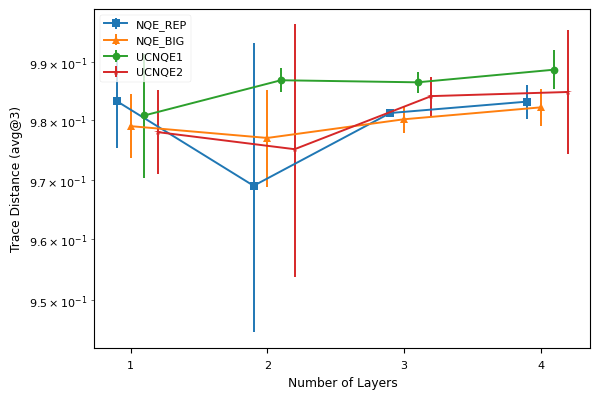

In [66]:
mean_tr_list_np = [[torch.mean(d, dim=0).detach().cpu().numpy() for d in l] for l in tr_list]
std_tr_list_np = [[torch.std(d, dim=0).detach().cpu().numpy() for d in l] for l in tr_list]

# mean_tr_list_np[3][2] = torch.mean(tr_list[3][3][:4], dim=0).detach().cpu().numpy()
# std_tr_list_np[3][2] = torch.std(tr_list[3][3][:4], dim=0).detach().cpu().numpy()

offset = np.full(len(n_layers_list), 0.1)

plt.errorbar(x=n_layers_list-offset,
             y=mean_tr_list_np[0],
             yerr=std_tr_list_np[0],
             label='NQE_REP', marker='s')
plt.errorbar(x=n_layers_list,
             y=mean_tr_list_np[1],
             yerr=std_tr_list_np[1],
             label='NQE_BIG', marker='^')
plt.errorbar(x=n_layers_list+offset,
             y=mean_tr_list_np[2],
             yerr=std_tr_list_np[2],
             label='UCNQE1', marker='o')
plt.errorbar(x=n_layers_list+offset*2,
             y=mean_tr_list_np[3],
             yerr=std_tr_list_np[3],
             label='UCNQE2', marker='*')

plt.xticks(n_layers_list)
plt.yscale('log')
plt.legend()
plt.ylabel(f'Trace Distance (avg@{avg_at})')
plt.xlabel('Number of Layers')
plt.show()

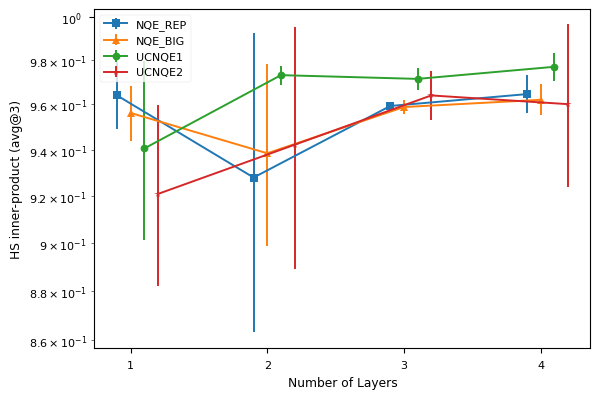

In [67]:
mean_hs_list_np = [[torch.mean(d, dim=0).detach().cpu().numpy() for d in l] for l in hs_list]
std_hs_list_np = [[torch.std(d, dim=0).detach().cpu().numpy() for d in l] for l in hs_list]

# mean_hs_list_np[3][2] = torch.mean(hs_list[3][3][:4], dim=0).detach().cpu().numpy()
# std_hs_list_np[3][2] = torch.std(hs_list[3][3][:4], dim=0).detach().cpu().numpy()

offset = np.full(len(n_layers_list), 0.1)

plt.errorbar(x=n_layers_list-offset,
             y=mean_hs_list_np[0],
             yerr=std_hs_list_np[0],
             label='NQE_REP', marker='s')
plt.errorbar(x=n_layers_list,
             y=mean_hs_list_np[1],
             yerr=std_hs_list_np[1],
             label='NQE_BIG', marker='^')
plt.errorbar(x=n_layers_list+offset,
             y=mean_hs_list_np[2],
             yerr=std_hs_list_np[2],
             label='UCNQE1', marker='o')
plt.errorbar(x=n_layers_list+offset*2,
             y=mean_hs_list_np[3],
             yerr=std_hs_list_np[3],
             label='UCNQE2', marker='*')

plt.xticks(n_layers_list)
plt.yscale('log')
plt.legend()
plt.ylabel(f'HS inner-product (avg@{avg_at})')
plt.xlabel('Number of Layers')
plt.show()

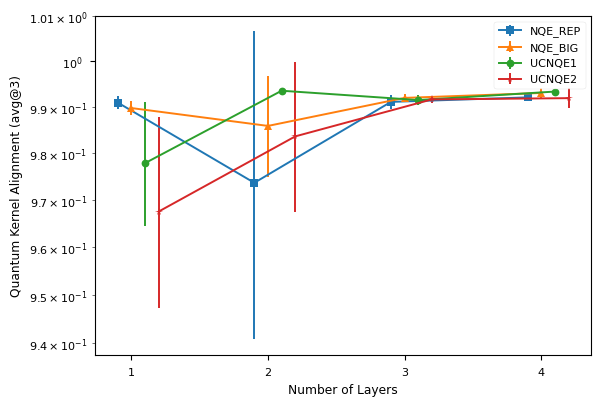

In [68]:
mean_qka_list_np = [[torch.mean(d, dim=0).detach().cpu().numpy() for d in l] for l in qka_list]
std_qka_list_np = [[torch.std(d, dim=0).detach().cpu().numpy() for d in l] for l in qka_list]

offset = np.full(len(n_layers_list), 0.1)

plt.errorbar(x=n_layers_list-offset,
             y=mean_qka_list_np[0],
             yerr=std_qka_list_np[0],
             label='NQE_REP', marker='s')
plt.errorbar(x=n_layers_list,
             y=mean_qka_list_np[1],
             yerr=std_qka_list_np[1],
             label='NQE_BIG', marker='^')
plt.errorbar(x=n_layers_list+offset,
             y=mean_qka_list_np[2],
             yerr=std_qka_list_np[2],
             label='UCNQE1', marker='o')
plt.errorbar(x=n_layers_list+offset*2,
             y=mean_qka_list_np[3],
             yerr=std_qka_list_np[3],
             label='UCNQE2', marker='*')

plt.xticks(n_layers_list)
plt.yscale('log')
plt.legend()
plt.ylabel(f'Quantum Kernel Alignment (avg@{avg_at})')
plt.xlabel('Number of Layers')
plt.show()

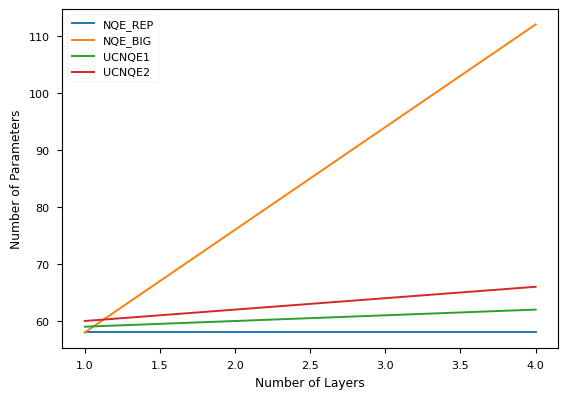

In [69]:
plt.plot(n_layers_list, param_size_list[0], label='NQE_REP')
plt.plot(n_layers_list, param_size_list[1], label='NQE_BIG')
plt.plot(n_layers_list, param_size_list[2], label='UCNQE1')
plt.plot(n_layers_list, param_size_list[3], label='UCNQE2')
plt.legend()
plt.ylabel('Number of Parameters')
plt.xlabel('Number of Layers')
plt.show()

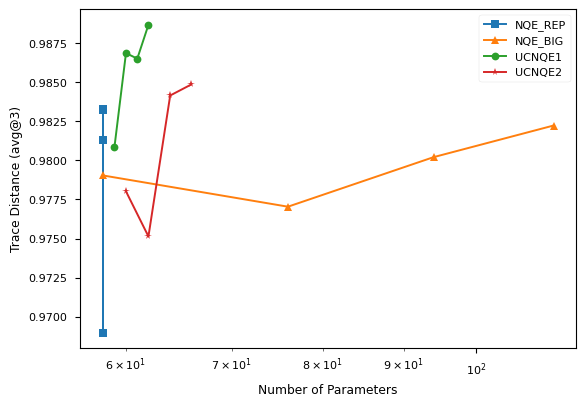

In [70]:
plt.plot(param_size_list[0], mean_tr_list_np[0], label='NQE_REP', marker='s')
plt.plot(param_size_list[1], mean_tr_list_np[1], label='NQE_BIG', marker='^')
plt.plot(param_size_list[2], mean_tr_list_np[2], label='UCNQE1', marker='o')
plt.plot(param_size_list[3], mean_tr_list_np[3], label='UCNQE2', marker='*')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.ylabel(f'Trace Distance (avg@{avg_at})')
plt.xlabel('Number of Parameters')
plt.show()

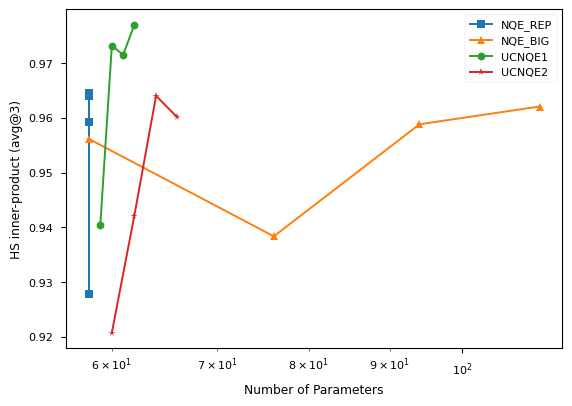

In [71]:
plt.plot(param_size_list[0], mean_hs_list_np[0], label='NQE_REP', marker='s')
plt.plot(param_size_list[1], mean_hs_list_np[1], label='NQE_BIG', marker='^')
plt.plot(param_size_list[2], mean_hs_list_np[2], label='UCNQE1', marker='o')
plt.plot(param_size_list[3], mean_hs_list_np[3], label='UCNQE2', marker='*')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.ylabel(f'HS inner-product (avg@{avg_at})')
plt.xlabel('Number of Parameters')
plt.show()

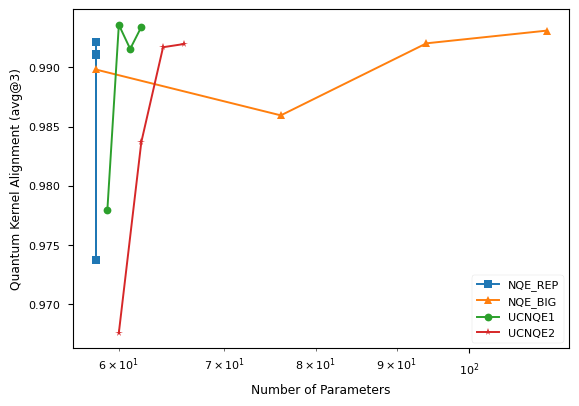

In [72]:
plt.plot(param_size_list[0], mean_qka_list_np[0], label='NQE_REP', marker='s')
plt.plot(param_size_list[1], mean_qka_list_np[1], label='NQE_BIG', marker='^')
plt.plot(param_size_list[2], mean_qka_list_np[2], label='UCNQE1', marker='o')
plt.plot(param_size_list[3], mean_qka_list_np[3], label='UCNQE2', marker='*')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.ylabel(f'Quantum Kernel Alignment (avg@{avg_at})')
plt.xlabel('Number of Parameters')
plt.show()

In [33]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True, sharey=True)
# for i, ax in enumerate(axs):
#     for j, L in enumerate(dist_list[i], 1):
#         ax.plot(L.detach().numpy(), label=j)
# ax.legend()
# plt.show()

# QCNN

### Utils

In [34]:
def get_random_data_qcnn(batch_size, X, Y):
    X_new, Y_new = [], []
    for i in range(batch_size):
        n = numpy.random.randint(len(X))
        X_new.append(X[n])
        Y_new.append(Y[n])

    X_new = torch.as_tensor(numpy.array(X_new), dtype=torch.float32)
    Y_new = torch.as_tensor(numpy.array(Y_new), dtype=torch.float32)
    return X_new, Y_new

def build_train_loader_qcnn(X_train, Y_train, batch_size, *, n=5000):
    train_loader = []
    for i in range(n):
        X, Y = get_random_data_qcnn(batch_size, X_train, Y_train)
        train_loader.append((X, Y))
    return train_loader


def build_validation_loader_qcnn(X_val, Y_val, batch_size, *, n=32):
    val_loader = []
    for i in range(n):
        X, Y = get_random_data_qcnn(batch_size, X_val, Y_val)
        val_loader.append((X, Y))
    return val_loader

@torch.no_grad()
def compute_val_loss_qcnn(model, val_loader, loss_fn, device):
    model.eval()
    acc_loss = 0.0
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device).to(torch.float32)
        out = model(X)
        acc_loss += float(loss_fn(out, Y).item())
    return acc_loss / len(val_loader)

def train_with_early_stopping_qcnn(model, train_loader, val_loader, test_loader, optimizer,
                                    *, max_steps=5000, batch_size=256, device=None,
                                    validate_every=25, patience=300, warm_up=100,
                                    min_delta=1e-4, scheduler=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    loss_fn = nn.MSELoss()
    stopper = EarlyStopper(patience=patience, min_delta=min_delta, warmup=warm_up)

    # Optional LR scheduler on plateau (monitors val loss)
    sched = None
    if scheduler:
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=max(validate_every//2, 20),
            threshold=min_delta, min_lr=1e-5
        )

    train_loss_hist, val_loss_hist = [], []
    acc_hist = []
    auc_hist = []
    for step, (X, Y) in tqdm(enumerate(train_loader), desc=f'{model.__class__.__name__}-{model.nqe.__class__.__name__}'):
        X, Y = X.to(device), Y.to(device).to(torch.float32)  # Cast Y to float32

        model.train()
        out = model(X)
        loss = loss_fn(out, Y)

        optimizer.zero_grad()
        c_layer_before = model.nqe.linear
        loss.backward()
        optimizer.step()
        c_layer_after = model.nqe.linear
        train_loss_hist.append(float(loss.item()))

        for i in range(len(c_layer_before)):
            if hasattr(c_layer_before[i], 'weight'):
                assert torch.allclose(c_layer_before[i].weight, c_layer_after[i].weight, atol=1e-4)


        # periodic validation & test
        if (step % validate_every) == 0:
            correct = 0
            model.eval()
            with torch.no_grad():
                test_score, test_label = [], []
                for X, Y in test_loader:
                    X, Y = X.to(device), Y.to(device).to(torch.float32)
                    out = model(X)
                    correct += (torch.round(out) == Y).sum().item()
                    test_score.append(out.cpu().numpy())
                    test_label.append(Y.cpu().numpy())
                test_score = np.concatenate(test_score)
                test_label = np.concatenate(test_label)
            acc = correct / len(test_loader.dataset)
            acc_hist.append(acc)
            auc = roc_auc_score(test_label, test_score)
            auc_hist.append(auc)

            vloss = compute_val_loss_qcnn(model, val_loader, loss_fn, device)
            val_loss_hist.append(vloss)
            if sched is not None:
                sched.step(vloss)

            should_stop, improved = stopper.step(vloss, step, model)
            if step % (validate_every*4) == 0:
                print(f"[{step:>4}] train={train_loss_hist[-1]:.4f} val={vloss:.4f} acc={acc:.4f}"
                      f" best@{stopper.best_step}={stopper.best:.4f}")
            if should_stop:
                print(f"Early stop at step {step} (best val {stopper.best:.4f} @ {stopper.best_step})")
                break

    # restore best weights (if we improved at least once)
    if stopper.best_state is not None:
        model.load_state_dict(stopper.best_state)

    return {
        "train_loss": torch.tensor(train_loss_hist),
        "val_loss": torch.tensor(val_loss_hist),
        "acc": torch.tensor(acc_hist),
        "auc": torch.tensor(auc_hist),
        "best_val": stopper.best,
        "best_step": stopper.best_step,
        "final_step": step,
    }

### SU2 & SU4

In [35]:
def SU2(params, wires):
    """ZYZ Euler single-qubit SU(2): RZ(phi) RY(theta) RZ(lambda)."""
    qml.RZ(params[0], wires=wires)
    qml.RY(params[1], wires=wires)
    qml.RZ(params[2], wires=wires)

def SU4(params, wires, *, cartan_sign='ising'):
    """
    Apply a general two-qubit SU(4) using 15 parameters.

    Parameters
    ----------
    params : sequence[float] of length 15
        Layout = [L0(3), L1(3), C(3), R0(3), R1(3)]
        - L0, L1: left local SU(2) Euler angles on qubit 0 and 1
        - C:      Cartan (nonlocal) angles for XX, YY, ZZ
        - R0, R1: right local SU(2) Euler angles on qubit 0 and 1
    wires : Sequence[int] or Sequence[Any]
        Exactly two wires, e.g. [q0, q1].
    cartan_sign : {"ising", "canonical"}, optional
        "ising": C are the raw angles used in PennyLane’s IsingXX/YY/ZZ,
                 which implement exp(-i * angle/2 * P⊗P).
        "canonical": interpret C = (α, β, γ) of exp(+i α XX) exp(+i β YY) exp(+i γ ZZ);
                     internally maps to Ising angles = (-2α, -2β, -2γ).

    Notes
    -----
    - This is the standard KAK (Cartan) factorization:
        (SU2 ⊗ SU2) · exp(i α XX) exp(i β YY) exp(i γ ZZ) · (SU2 ⊗ SU2)
      which is universal for SU(4) (up to a global phase).
    - Differentiable with all PennyLane interfaces.
    """
    if len(wires) != 2:
        raise ValueError("SU4 requires exactly two wires.")
    if qml.math.size(params) != 15:
        raise ValueError("SU4 expects 15 parameters.")

    # Unpack
    p = qml.math.asarray(params)
    L0 = p[0:3]
    L1 = p[3:6]
    C  = p[6:9]
    R0 = p[9:12]
    R1 = p[12:15]

    # Local pre-rotations
    SU2(L0, wires=wires[0])
    SU2(L1, wires=wires[1])

    # Nonlocal Cartan block
    if cartan_sign == "canonical":
        # map exp(+i α XX) → IsingXX(-2α) since IsingXX(φ) = exp(-i φ/2 XX)
        cx, cy, cz = (-2*C[0], -2*C[1], -2*C[2])
    elif cartan_sign == "ising":
        cx, cy, cz = (C[0], C[1], C[2])
    else:
        raise ValueError("cartan_sign must be 'ising' or 'canonical'.")

    qml.IsingXX(cx, wires=wires)
    qml.IsingYY(cy, wires=wires)
    qml.IsingZZ(cz, wires=wires)

    # Local post-rotations
    SU2(R0, wires=wires[0])
    SU2(R1, wires=wires[1])


### QCNN ansatz block

In [36]:
class Ansatz:
    def __init__(self, n_qubits, mode):
        self.n_qubits = n_qubits
        self.mode = mode
        if mode == "SU4":
            # First layer: floor(n/2) gates on (0,1), (2,3), ...
            # Second layer: floor((n-1)/2) gates on (1,2), (3,4), ...
            g1 = n_qubits // 2
            g2 = (n_qubits - 1) // 2
            self._layout = ([(0 + 2*i, 1 + 2*i) for i in range(g1)] +
                            [(1 + 2*i, 2 + 2*i) for i in range(g2)])
            self.num_ansatz_params = 15 * (g1 + g2)
        elif mode == "TTN":
            # Simple left-collapsing TTN with SU4s; ~ (n_qubits - 1) gates + single SU2 gate
            self.num_ansatz_params = max(0, self.n_qubits - 1) * 15 + 3
        else:
            raise ValueError(f"Unknown ansatz mode: {mode}")

    def apply(self, params):
        if self.mode == "SU4":
            p = 0
            for (a, b) in self._layout:
                SU4(params[p:p+15], wires=[a, b])
                p += 15
            SU2(params[p:p+3], wires=[0])
        else:  # TTN
            wires = list(range(self.n_qubits))
            p = 0
            while len(wires) > 1:
                new_wires = []
                for i in range(0, len(wires) - 1, 2):
                    SU4(params[p:p+15], wires=[wires[i], wires[i+1]])
                    p += 15
                    new_wires.append(wires[i])
                if len(wires) % 2 != 0:
                    new_wires.append(wires[-1])
                wires = new_wires
            SU2(params[p:p+3], wires=[0])


@torch.no_grad()
def _to_layers_from_nqe(nqe, x):
    """Produce (B, n_qubits * n_layers) from any of the provided NQE variants."""
    if hasattr(nqe, "up_conv"):  # UCNQE path
        nqe.c_layer.eval()
        return nqe.c_layer(x)
    elif hasattr(nqe, "stacking"):  # NQE_repeat path
        nqe.c_layer.eval()
        return nqe.c_layer(x)
    else:  # NQE_one_big_layer
        nqe.linear.eval()
        return nqe.linear(x)


class QCNN(nn.Module):
    def __init__(self, n_qubits, nqe, ansatz_mode):
        super(QCNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = nqe.n_layers
        self.nqe = nqe
        self.embedding = nqe.q_embedding._embedding
        self.ansatz = Ansatz(n_qubits, ansatz_mode)
        self.eps = 1e-6

        self.params = nn.Parameter(torch.zeros(self.ansatz.num_ansatz_params))

        @qml.qnode(device=nqe.q_embedding.dev, interface='torch')
        def qc_expval(inputs, params):
            self.embedding(inputs)
            self.ansatz.apply(params)
            return qml.expval(qml.PauliZ(0))
        self.qc = qc_expval

        @qml.qnode(device=nqe.q_embedding.dev, interface='torch')
        def qc_dm(inputs, params):
            self.embedding(inputs)
            self.ansatz.apply(params)
            return qml.density_matrix(0)
        self.qc_dm = qc_dm

    def forward(self, x, for_visual=False):
        qfeat = _to_layers_from_nqe(self.nqe, x)

        if for_visual:
            return self.qc_dm(qfeat, self.params)     # density matrix of the first qubit

        y = self.qc(qfeat, self.params)               # expval in [-1, 1]
        y = (y + 1.0) * 0.5                           # map to [0, 1]
        return torch.clamp(y, self.eps, 1.0 - self.eps)

### Test

In [37]:
nqe = NQE(in_dims=4, n_qubits=1, n_layers=1, hidden_dims=[6],
          q_embedding=QLayer(ZZFeatureMap, n_qubits=1))
qcnn = QCNN(n_qubits=1, nqe=nqe, ansatz_mode='TTN')

X_train, Y_train, X_test, Y_test = load_mnist_pca(4)
# X_train, Y_train, X_test, Y_test = load_fashion_mnist_pca(input_dims)

val_frac = 0.1
n = len(X_train)
idx = numpy.random.permutation(n)
cut = int(n*(1.0 - val_frac))
tr_idx, va_idx = idx[:cut], idx[cut:]
X_va, Y_va = X_train[va_idx], Y_train[va_idx]
X_tr, Y_tr = X_train[tr_idx], Y_train[tr_idx]

train_loader = build_train_loader_qcnn(X_tr, Y_tr, batch_size=128, n=1000)
val_loader   = build_validation_loader_qcnn(X_va, Y_va, batch_size=128, n=32)
test_loader  = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.as_tensor(X_test, dtype=torch.float32),
                                                                          torch.as_tensor(Y_test, dtype=torch.float32)),
                                            batch_size=128, shuffle=False)

optimizer = torch.optim.SGD(qcnn.parameters(), lr=1e-2)
# res = train_with_early_stopping_qcnn(qcnn, train_loader, val_loader, test_loader, optimizer=optimizer)

In [38]:
# plt.plot(numpy.arange(1000), res['train_loss'], label='train')
# plt.plot(numpy.arange(0, 1000, 25), res['val_loss'], label='val')
# plt.legend()
# plt.plot()

QCNN: 0it [00:00, ?it/s]

Epoch [   0] Loss: 0.693147
Epoch [ 200] Loss: 0.681602
Epoch [ 400] Loss: 0.694308
Epoch [ 600] Loss: 0.659275
Epoch [ 800] Loss: 0.642663


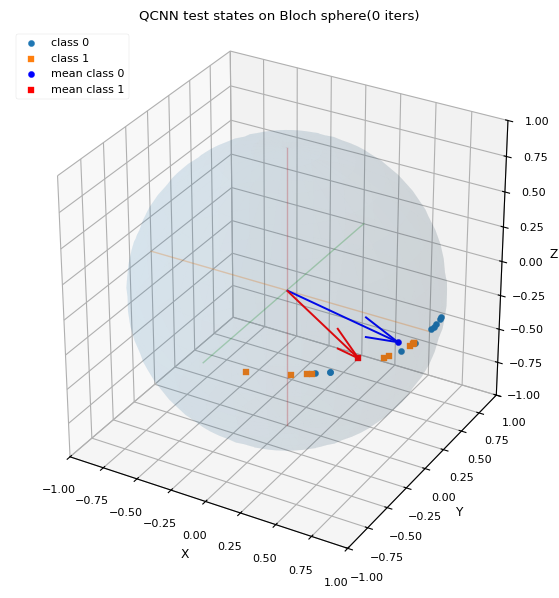

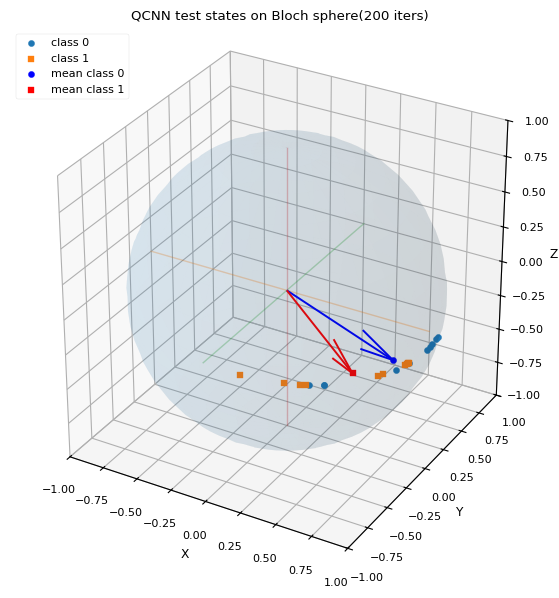

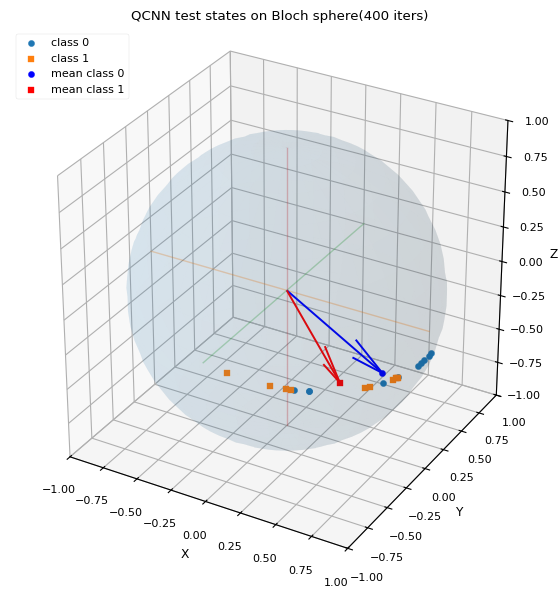

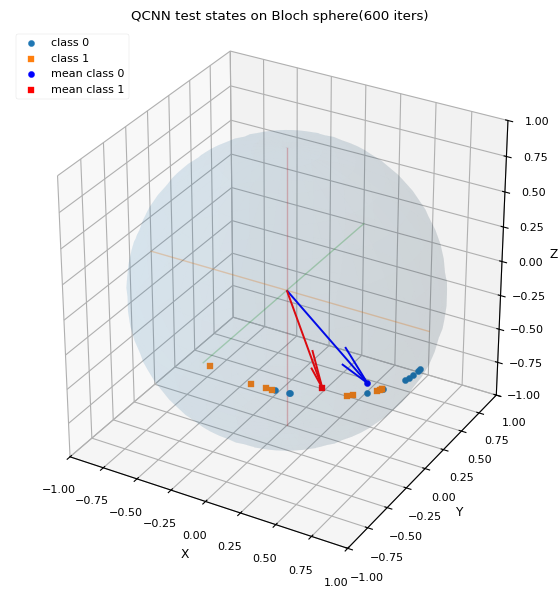

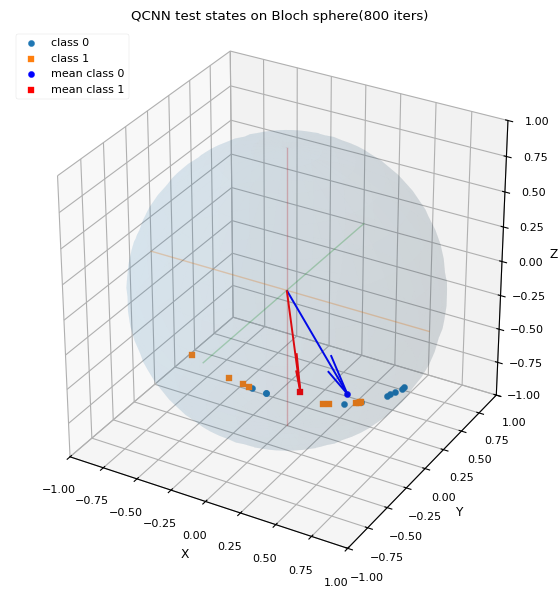

In [39]:
qcnn = QCNN(n_qubits=1, nqe=nqe_vis, ansatz_mode='TTN')

X_train, Y_train, X_test, Y_test = load_mnist_pca(4)
# X_train, Y_train, X_test, Y_test = load_fashion_mnist_pca(input_dims)

train_loader = build_train_loader_qcnn(X_tr, Y_tr, batch_size=128, n=1000)

K = 10  # points per class to visualize
idx0 = np.where(Y_test == 0)[0][:K]
idx1 = np.where(Y_test == 1)[0][:K]
Xt0 = torch.as_tensor(X_test[idx0], dtype=torch.float32, device=device)
Xt1 = torch.as_tensor(X_test[idx1], dtype=torch.float32, device=device)

nqe_vis = nqe_vis.to(device)
qcnn = qcnn.to(device)
optimizer = torch.optim.SGD(qcnn.parameters(), lr=1e-2)

loss_fn = nn.BCELoss()
train_loss = []
dm_list = []

for i, (X, Y) in tqdm(enumerate(train_loader), desc=f'{qcnn.__class__.__name__}'):
    X, Y = X.to(device), Y.to(device).to(torch.float64)

    qcnn.train()
    output = qcnn(X)
    loss = loss_fn(output, Y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    train_loss.append(loss.item())
    if i % 200 == 0:
        print(f'Epoch [{i:>4}] Loss: {loss.item():.6f}')

        # ---- embed and get density matrices in batch ----
        qcnn.eval()
        with torch.no_grad():
            dm0 = qcnn(Xt0, for_visual=True)  # (K,2,2)
            dm1 = qcnn(Xt1, for_visual=True)  # (K,2,2)
        dm_list.append((dm0, dm1))


for i, (dm0, dm1) in enumerate(dm_list):
    # ---- convert to Bloch coordinates ----
    x0,y0,z0 = _bloch_from_dm(dm0)
    x1,y1,z1 = _bloch_from_dm(dm1)

    # ---- plot ----
    _plot_bloch_points(x0,y0,z0, x1,y1,z1, title=f"QCNN test states on Bloch sphere({i*200} iters)")


### Comparison

In [40]:
# ----- Hyper-Params for QCNN -----
n_qubits = 2
input_dims = 4
hidden_dims = [6]
n_layers_list = [1, 2, 3]
batch_size = 128
max_steps = 300
patience = 1000
warm_up = 100
avg_at = 5

# ----- Results Containers -----
train_list = torch.full((3, len(n_layers_list), avg_at, max_steps), float('nan'))
val_list   = torch.full((3, len(n_layers_list), avg_at, max_steps // 25), float('nan'))
acc_list   = torch.full((3, len(n_layers_list), avg_at), float('nan'))
auc_list   = torch.full((3, len(n_layers_list), avg_at), float('nan'))

# ----- Dataset -----
# X_train, Y_train, X_test, Y_test = load_mnist_pca(input_dims)
X_train, Y_train, X_test, Y_test = load_fashion_mnist_pca(input_dims)

val_frac = 0.1
n = len(X_train)
idx = numpy.random.permutation(n)
cut = int(n*(1.0 - val_frac))
tr_idx, va_idx = idx[:cut], idx[cut:]
X_va, Y_va = X_train[va_idx], Y_train[va_idx]
X_tr, Y_tr = X_train[tr_idx], Y_train[tr_idx]

# ----- Main Loop -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = build_train_loader_qcnn(X_tr, Y_tr, batch_size=batch_size, n=max_steps)
val_loader   = build_validation_loader_qcnn(X_va, Y_va, batch_size=128, n=32)
test_loader  = DataLoader(TensorDataset(torch.as_tensor(X_test, dtype=torch.float32),
                                        torch.as_tensor(Y_test, dtype=torch.float32)), batch_size=128, shuffle=False)

for i, n_layers in enumerate(n_layers_list):
    print(f'[Number of layers: {n_layers}]')
    model0 = NQE(in_dims=input_dims,
                    n_qubits=n_qubits,
                    n_layers=n_layers,
                    hidden_dims=hidden_dims,
                    q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))
    model1 = NQE_one_big_layer(in_dims=input_dims,
                                n_qubits=n_qubits,
                                n_layers=n_layers,
                                hidden_dims=hidden_dims,
                                q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))
    model2 = UCNQE(in_dims=input_dims,
                    n_qubits=n_qubits,
                    n_layers=n_layers,
                    hidden_dims=hidden_dims,
                    q_embedding=QLayer(ZZFeatureMap, n_qubits=n_qubits))

    try:
        # raise Exception
        model0.load_state_dict(torch.load(f'NQE-L{n_layers}.pt'))
        model1.load_state_dict(torch.load(f'NQE_BIG-L{n_layers}.pt'))
        model2.load_state_dict(torch.load(f'UCNQE2-L{n_layers}.pt'))

    except Exception as e:
        print(e)
        print('No pre-trained model detected: Start Training...')
        optimizer0 = torch.optim.Adam(model0.parameters(), lr=1e-2)
        optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-2)
        optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-2)

        train_loader = build_train_loader(X_tr, Y_tr, batch_size, n=5000)
        val_loader   = build_validation_loader(X_va, Y_va, batch_size, n=32)

        nqe_res    = train_with_early_stopping(model0, train_loader, val_loader, optimizer0,
                                            max_steps=5000, batch_size=batch_size,
                                            patience=500, warm_up=warm_up, scheduler=False,
                                            device=device)
        nqebig_res = train_with_early_stopping(model1, train_loader, val_loader, optimizer1,
                                            max_steps=5000, batch_size=batch_size,
                                            patience=500, warm_up=warm_up, scheduler=False,
                                            device=device)
        ucnqe_res  = train_with_early_stopping(model2, train_loader, val_loader, optimizer2,
                                            max_steps=5000, batch_size=batch_size,
                                            patience=500, warm_up=warm_up, scheduler=False,
                                            device=device)

        torch.save(model0.state_dict(), f'NQE-L{n_layers}.pt')
        torch.save(model1.state_dict(), f'NQE_BIG-L{n_layers}.pt')
        torch.save(model2.state_dict(), f'UCNQE2-L{n_layers}.pt')

        try:
            import google.colab.files as files
            files.download(f'NQE-L{n_layers}.pt')
            files.download(f'NQE_BIG-L{n_layers}.pt')
            files.download(f'UCNQE2-L{n_layers}.pt')
        except Exception as e:
            print(f'Download failed: {e}')


    for j in range(avg_at):
        print(f'\n[{j+1}/{avg_at}]')
        qcnn0 = QCNN(n_qubits=n_qubits, nqe=model0, ansatz_mode='TTN')
        qcnn1 = QCNN(n_qubits=n_qubits, nqe=model1, ansatz_mode='TTN')
        qcnn2 = QCNN(n_qubits=n_qubits, nqe=model2, ansatz_mode='TTN')

        optimizer0 = torch.optim.SGD(qcnn0.parameters(), lr=1e-2)
        optimizer1 = torch.optim.SGD(qcnn1.parameters(), lr=1e-2)
        optimizer2 = torch.optim.SGD(qcnn2.parameters(), lr=1e-2)

        res0 = train_with_early_stopping_qcnn(qcnn0, train_loader, val_loader, test_loader, optimizer=optimizer0,
                                              max_steps=max_steps, patience=patience)
        res1 = train_with_early_stopping_qcnn(qcnn1, train_loader, val_loader, test_loader, optimizer=optimizer1,
                                              max_steps=max_steps, patience=patience)
        res2 = train_with_early_stopping_qcnn(qcnn2, train_loader, val_loader, test_loader, optimizer=optimizer2,
                                              max_steps=max_steps, patience=patience)

        train_list[0, i, j, :len(res0['train_loss'])] = res0['train_loss']
        train_list[1, i, j, :len(res1['train_loss'])] = res1['train_loss']
        train_list[2, i, j, :len(res2['train_loss'])] = res2['train_loss']

        val_list[0, i, j, :len(res0['val_loss'])] = res0['val_loss']
        val_list[1, i, j, :len(res1['val_loss'])] = res1['val_loss']
        val_list[2, i, j, :len(res2['val_loss'])] = res2['val_loss']

        acc_list[0, i, j] = res0['acc'][-1]
        acc_list[1, i, j] = res1['acc'][-1]
        acc_list[2, i, j] = res2['acc'][-1]

        auc_list[0, i, j] = res0['auc'][-1]
        auc_list[1, i, j] = res1['auc'][-1]
        auc_list[2, i, j] = res2['auc'][-1]



100%|██████████| 26.4M/26.4M [00:03<00:00, 8.53MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 134kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


[Number of layers: 1]


NameError: name 'NQE_one_big_layer' is not defined

In [ ]:
nqe_train_mean = torch.mean(train_list[0], dim=1)
nqebig_train_mean = torch.mean(train_list[1], dim=1)
ucnqe_train_mean = torch.mean(train_list[2], dim=1)

nqe_train_std = torch.std(train_list[0], dim=1)
nqebig_train_std = torch.std(train_list[1], dim=1)
ucnqe_train_std = torch.std(train_list[2], dim=1)

nqe_val_mean = torch.mean(val_list[0], dim=1)
nqebig_val_mean = torch.mean(val_list[1], dim=1)
ucnqe_val_mean = torch.mean(val_list[2], dim=1)

nqe_val_std = torch.std(val_list[0], dim=1)
nqebig_val_std = torch.std(val_list[1], dim=1)
ucnqe_val_std = torch.std(val_list[2], dim=1)

nqe_acc_mean = torch.mean(acc_list[0], dim=1)
nqebig_acc_mean = torch.mean(acc_list[1], dim=1)
ucnqe_acc_mean = torch.mean(acc_list[2], dim=1)

nqe_acc_std = torch.std(acc_list[0], dim=1)
nqebig_acc_std = torch.std(acc_list[1], dim=1)
ucnqe_acc_std = torch.std(acc_list[2], dim=1)

nqe_auc_mean = torch.mean(auc_list[0], dim=1)
nqebig_auc_mean = torch.mean(auc_list[1], dim=1)
ucnqe_auc_mean = torch.mean(auc_list[2], dim=1)

nqe_auc_std = torch.std(auc_list[0], dim=1)
nqebig_auc_std = torch.std(auc_list[1], dim=1)
ucnqe_auc_std = torch.std(auc_list[2], dim=1)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True, tight_layout=True)
steps = np.arange(max_steps)

for L in range(5):
    axs[0].plot(steps, nqe_train_mean[L], label=f'NQE-L{L+1}')
    axs[0].fill_between(steps, nqe_train_mean[L] - nqe_train_std[L], nqe_train_mean[L] + nqe_train_std[L], alpha=0.2)

    axs[1].plot(steps, nqebig_train_mean[L], label=f'NQE_BIG-L{L+1}')
    axs[1].fill_between(steps, nqebig_train_mean[L] - nqebig_train_std[L], nqebig_train_mean[L] + nqebig_train_std[L], alpha=0.2)

    axs[2].plot(steps, ucnqe_train_mean[L], label=f'UCNQE-L{L+1}')
    axs[2].fill_between(steps, ucnqe_train_mean[L] - ucnqe_train_std[L], ucnqe_train_mean[L] + ucnqe_train_std[L], alpha=0.2)


fig.supxlabel("Steps")
fig.supylabel("Train Loss (BCE)")
axs[0].set_title("NQE")
axs[1].set_title("NQE_BIG")
axs[2].set_title("UCNQE")

interactive_legend_for_fig(fig)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), tight_layout=True)
plt.style.use('seaborn-v0_8-paper')
steps = np.arange(max_steps)
for L, ax in enumerate(axs.flat[:-1]):
    ax.plot(steps, nqe_train_mean[L], label=f'NQE-L{L+1}')
    ax.fill_between(steps, nqe_train_mean[L] - nqe_train_std[L], nqe_train_mean[L] + nqe_train_std[L], alpha=0.2)

    ax.plot(steps, nqebig_train_mean[L], label=f'NQE_BIG-L{L+1}')
    ax.fill_between(steps, nqebig_train_mean[L] - nqebig_train_std[L], nqebig_train_mean[L] + nqebig_train_std[L], alpha=0.2)

    ax.plot(steps, ucnqe_train_mean[L], label=f'UCNQE-L{L+1}')
    ax.fill_between(steps, ucnqe_train_mean[L] - ucnqe_train_std[L], ucnqe_train_mean[L] + ucnqe_train_std[L], alpha=0.2)

    ax.legend()

fig.supxlabel("Steps")
fig.supylabel("Train Loss (BCE)")

interactive_legend_for_fig(fig)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, tight_layout=True)
steps = np.arange(0, max_steps, 25)
for L in range(5):
    axs[0].plot(steps, nqe_val_mean[L], label=f'NQE-L{L}')
    axs[0].fill_between(steps, nqe_val_mean[L] - nqe_val_std[L], nqe_val_mean[L] + nqe_val_std[L], alpha=0.2)

    axs[1].plot(steps, nqebig_val_mean[L], label=f'NQE_BIG-L{L}')
    axs[1].fill_between(steps, nqebig_val_mean[L] - nqebig_val_std[L], nqebig_val_mean[L] + nqebig_val_std[L], alpha=0.2)

    axs[2].plot(steps, ucnqe_val_mean[L], label=f'UCNQE-L{L}')
    axs[2].fill_between(steps, ucnqe_val_mean[L] - ucnqe_val_std[L], ucnqe_val_mean[L] + ucnqe_val_std[L], alpha=0.2)

fig.supxlabel("Steps")
fig.supylabel("Validation Loss (BCE)")
axs[0].set_title("NQE")
axs[1].set_title("NQE_BIG")
axs[2].set_title("UCNQE")
axs[0].legend()
axs[1].legend()
axs[2].legend()

interactive_legend_for_fig(fig)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), tight_layout=True)
steps = np.arange(0, max_steps, 25)
for L, ax in enumerate(axs.flat[:-1]):
    ax.plot(steps, nqe_val_mean[L], label=f'NQE-L{L+1}')
    ax.fill_between(steps, nqe_val_mean[L] - nqe_val_std[L], nqe_val_mean[L] + nqe_val_std[L], alpha=0.2)

    ax.plot(steps, nqebig_val_mean[L], label=f'NQE_BIG-L{L+1}')
    ax.fill_between(steps, nqebig_val_mean[L] - nqebig_val_std[L], nqebig_val_mean[L] + nqebig_val_std[L], alpha=0.2)

    ax.plot(steps, ucnqe_val_mean[L], label=f'UCNQE-L{L+1}')
    ax.fill_between(steps, ucnqe_val_mean[L] - ucnqe_val_std[L], ucnqe_val_mean[L] + ucnqe_val_std[L], alpha=0.2)

    ax.legend()

fig.supxlabel("Steps")
fig.supylabel("Train Loss (BCE)")

interactive_legend_for_fig(fig)

In [ ]:
plt.figure(figsize=(10, 7))

n_layers = [1, 2, 3, 4, 5]
plt.plot(n_layers, nqe_acc_mean, label=f'NQE')
plt.fill_between(n_layers, nqe_acc_mean - nqe_acc_std, nqe_acc_mean + nqe_acc_std, alpha=0.2)

plt.plot(n_layers, nqebig_acc_mean, label=f'NQE_BIG')
plt.fill_between(n_layers, nqebig_acc_mean - nqebig_acc_std, nqebig_acc_mean + nqebig_acc_std, alpha=0.2)

plt.plot(n_layers, ucnqe_acc_mean, label=f'UCNQE')
plt.fill_between(n_layers, ucnqe_acc_mean - ucnqe_acc_std, ucnqe_acc_mean + ucnqe_acc_std, alpha=0.2)

plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Layers")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))

n_layers = [1, 2, 3, 4, 5]
plt.plot(n_layers, nqe_auc_mean, label=f'NQE')
plt.fill_between(n_layers, nqe_auc_mean - nqe_auc_std, nqe_auc_mean + nqe_auc_std, alpha=0.2)

plt.plot(n_layers, nqebig_auc_mean, label=f'NQE_BIG')
plt.fill_between(n_layers, nqebig_auc_mean - nqebig_auc_std, nqebig_auc_mean + nqebig_auc_std, alpha=0.2)

plt.plot(n_layers, ucnqe_auc_mean, label=f'UCNQE')
plt.fill_between(n_layers, ucnqe_auc_mean - ucnqe_auc_std, ucnqe_auc_mean + ucnqe_auc_std, alpha=0.2)

plt.xlabel("Number of Layers")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs Number of Layers")
plt.legend()
plt.show()